In [ ]:

# ! pip install -qq PyMuPDF opencv-python numpy pandas Pillow pytesseract spacy scikit-learn
# ! pip install -qq fastapi uvicorn python-multipart

import os
import json
import re
import cv2
import numpy as np
import pandas as pd
from PIL import Image
from io import BytesIO

# Third-party libraries
import fitz # PyMuPDF for PDF handling
import pytesseract
import spacy
from spacy.tokens import DocBin
from sklearn.metrics import classification_report

# Placeholder: FastAPI components (will be used in the final API cell)
from fastapi import FastAPI, UploadFile, File
import uvicorn

# 2. Configuration and Path Setup
# Define the root data folder
DATA_DIR = 'project_data'

# Define subdirectories for inputs, outputs, and training data
INPUT_DIR = os.path.join(DATA_DIR, 'raw_input')
CLEANED_DIR = os.path.join(DATA_DIR, 'processed_images')
TOKEN_DIR = os.path.join(DATA_DIR, 'tokens')
FINAL_REPORTS_DIR = os.path.join(DATA_DIR, 'final_reports')
CORRECTIONS_DIR = os.path.join(DATA_DIR, 'training_data_corrections')

# Create directories if they do not exist
for d in [INPUT_DIR, CLEANED_DIR, TOKEN_DIR, FINAL_REPORTS_DIR, CORRECTIONS_DIR]:
    os.makedirs(d, exist_ok=True)

# IMPORTANT: Set Tesseract path (REQUIRED if not in system PATH)
# Example for Windows: pytesseract.pytesseract.tesseract_cmd = r'C:\Program Files\Tesseract-OCR\tesseract.exe'
# For Linux/macOS, it might just be 'tesseract' or you can omit this line if installed globally.
try:
    pytesseract.pytesseract.tesseract_cmd = 'tesseract' 
except:
    print("WARNING: Tesseract command not found. Please set the path correctly.")


# 3. Create a dummy input file for testing 
# DUMMY_PDF_PATH = os.path.join(INPUT_DIR, '17756177_50641000301.pdf')
DUMMY_PDF_PATH = os.path.join(INPUT_DIR, '32187653_MRS. SATHYAVATHY.pdf')
if not os.path.exists(DUMMY_PDF_PATH):
    print(f"Placeholder: Create a dummy PDF at {DUMMY_PDF_PATH} for testing.")
    # In a real scenario, you would manually place a report PDF here.
    # For now, we will assume one exists for the code structure demonstration.
    
print("Setup complete. Directories created and paths defined.")

Setup complete. Directories created and paths defined.


# Module 1: File Input & Preprocessing 

In [129]:

def deskew_image(image_cv: np.ndarray) -> tuple[np.ndarray, float]:
    """Applies a simple skew correction using image moments."""
    if len(image_cv.shape) == 3:
        gray = cv2.cvtColor(image_cv, cv2.COLOR_BGR2GRAY)
    else:
        gray = image_cv

    # Simple binary mask for contour finding
    _, binary = cv2.threshold(gray, 150, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)
    coords = np.column_stack(np.where(binary > 0))
    
    if coords.size == 0:
        return image_cv, 0
        
    rect = cv2.minAreaRect(coords)
    angle = rect[-1]

    if angle < -45:
        angle = -(90 + angle)
    else:
        angle = -angle

    (h, w) = image_cv.shape[:2]
    center = (w // 2, h // 2)
    M = cv2.getRotationMatrix2D(center, angle, 1.0)
    rotated = cv2.warpAffine(image_cv, M, (w, h),
        flags=cv2.INTER_CUBIC, borderMode=cv2.BORDER_REPLICATE)

    return rotated, angle

def preprocess_image(img_cv: np.ndarray) -> np.ndarray:
    """Applies deskewing, grayscale conversion, and OTSU thresholding."""
    if img_cv is None:
        return None

    # 1. Deskew
    deskewed_img = img_cv
    # deskewed_img, angle = deskew_image(img_cv)
    
    # 2. Convert to Grayscale
    if len(deskewed_img.shape) == 3:
        gray_img = cv2.cvtColor(deskewed_img, cv2.COLOR_BGR2GRAY)
    else:
        gray_img = deskewed_img

    # 3. Denoise and Threshold (OTSU) for optimal OCR quality
    blurred = cv2.GaussianBlur(gray_img, (5, 5), 0)
    _, final_clean_img = cv2.threshold(blurred, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    
    return final_clean_img

def convert_pdf_to_images(file_path: str) -> list[np.ndarray]:
    """Converts PDF pages to high-resolution OpenCV image arrays using PyMuPDF."""
    images = []
    try:
        doc = fitz.open(file_path)
        zoom = 4.16 # ~300 DPI
        matrix = fitz.Matrix(zoom, zoom)
        
        for page in doc:
            pix = page.get_pixmap(matrix=matrix, alpha=False)
            img_array = np.frombuffer(pix.samples, dtype=np.uint8).reshape(pix.h, pix.w, pix.n)
            img_cv = cv2.cvtColor(img_array, cv2.COLOR_RGB2BGR) 
            images.append(img_cv)
            
        doc.close()
    except Exception as e:
        print(f"Error processing PDF with PyMuPDF: {e}")
    return images

def process_report_file(file_path: str, output_base_name: str) -> list[str]:
    """Main function for Module 1: Handles input, preprocesses, and saves cleaned images."""
    cleaned_image_paths = []
    file_extension = file_path.lower().split('.')[-1]
    images_to_process = []

    if file_extension == 'pdf':
        print(f"Processing PDF: {file_path}")
        images_to_process = convert_pdf_to_images(file_path)
    
    elif file_extension in ['jpg', 'jpeg', 'png']:
        print(f"Processing image: {file_path}")
        img_cv = cv2.imread(file_path)
        if img_cv is not None:
            images_to_process.append(img_cv)
    
    else:
        print(f"Unsupported file type: {file_extension}")
        return []

    for i, img_cv in enumerate(images_to_process):
        cleaned_img_cv = preprocess_image(img_cv)
        
        output_filename = f"{output_base_name}_page_{i+1:02d}.png"
        output_path = os.path.join(CLEANED_DIR, output_filename) 
        cv2.imwrite(output_path, cleaned_img_cv)
        cleaned_image_paths.append(output_path)
        print(f"Saved cleaned image to: {output_path}")

    return cleaned_image_paths

## Test Module 1

Processing PDF: project_data\raw_input\32187653_MRS. SATHYAVATHY.pdf
Saved cleaned image to: project_data\processed_images\32187653_MRS. SATHYAVATHY_page_01.png
Saved cleaned image to: project_data\processed_images\32187653_MRS. SATHYAVATHY_page_02.png

✅ Module 1 Success. Found 2 cleaned image(s).
Displaying the first cleaned image (Binary, Deskewed):


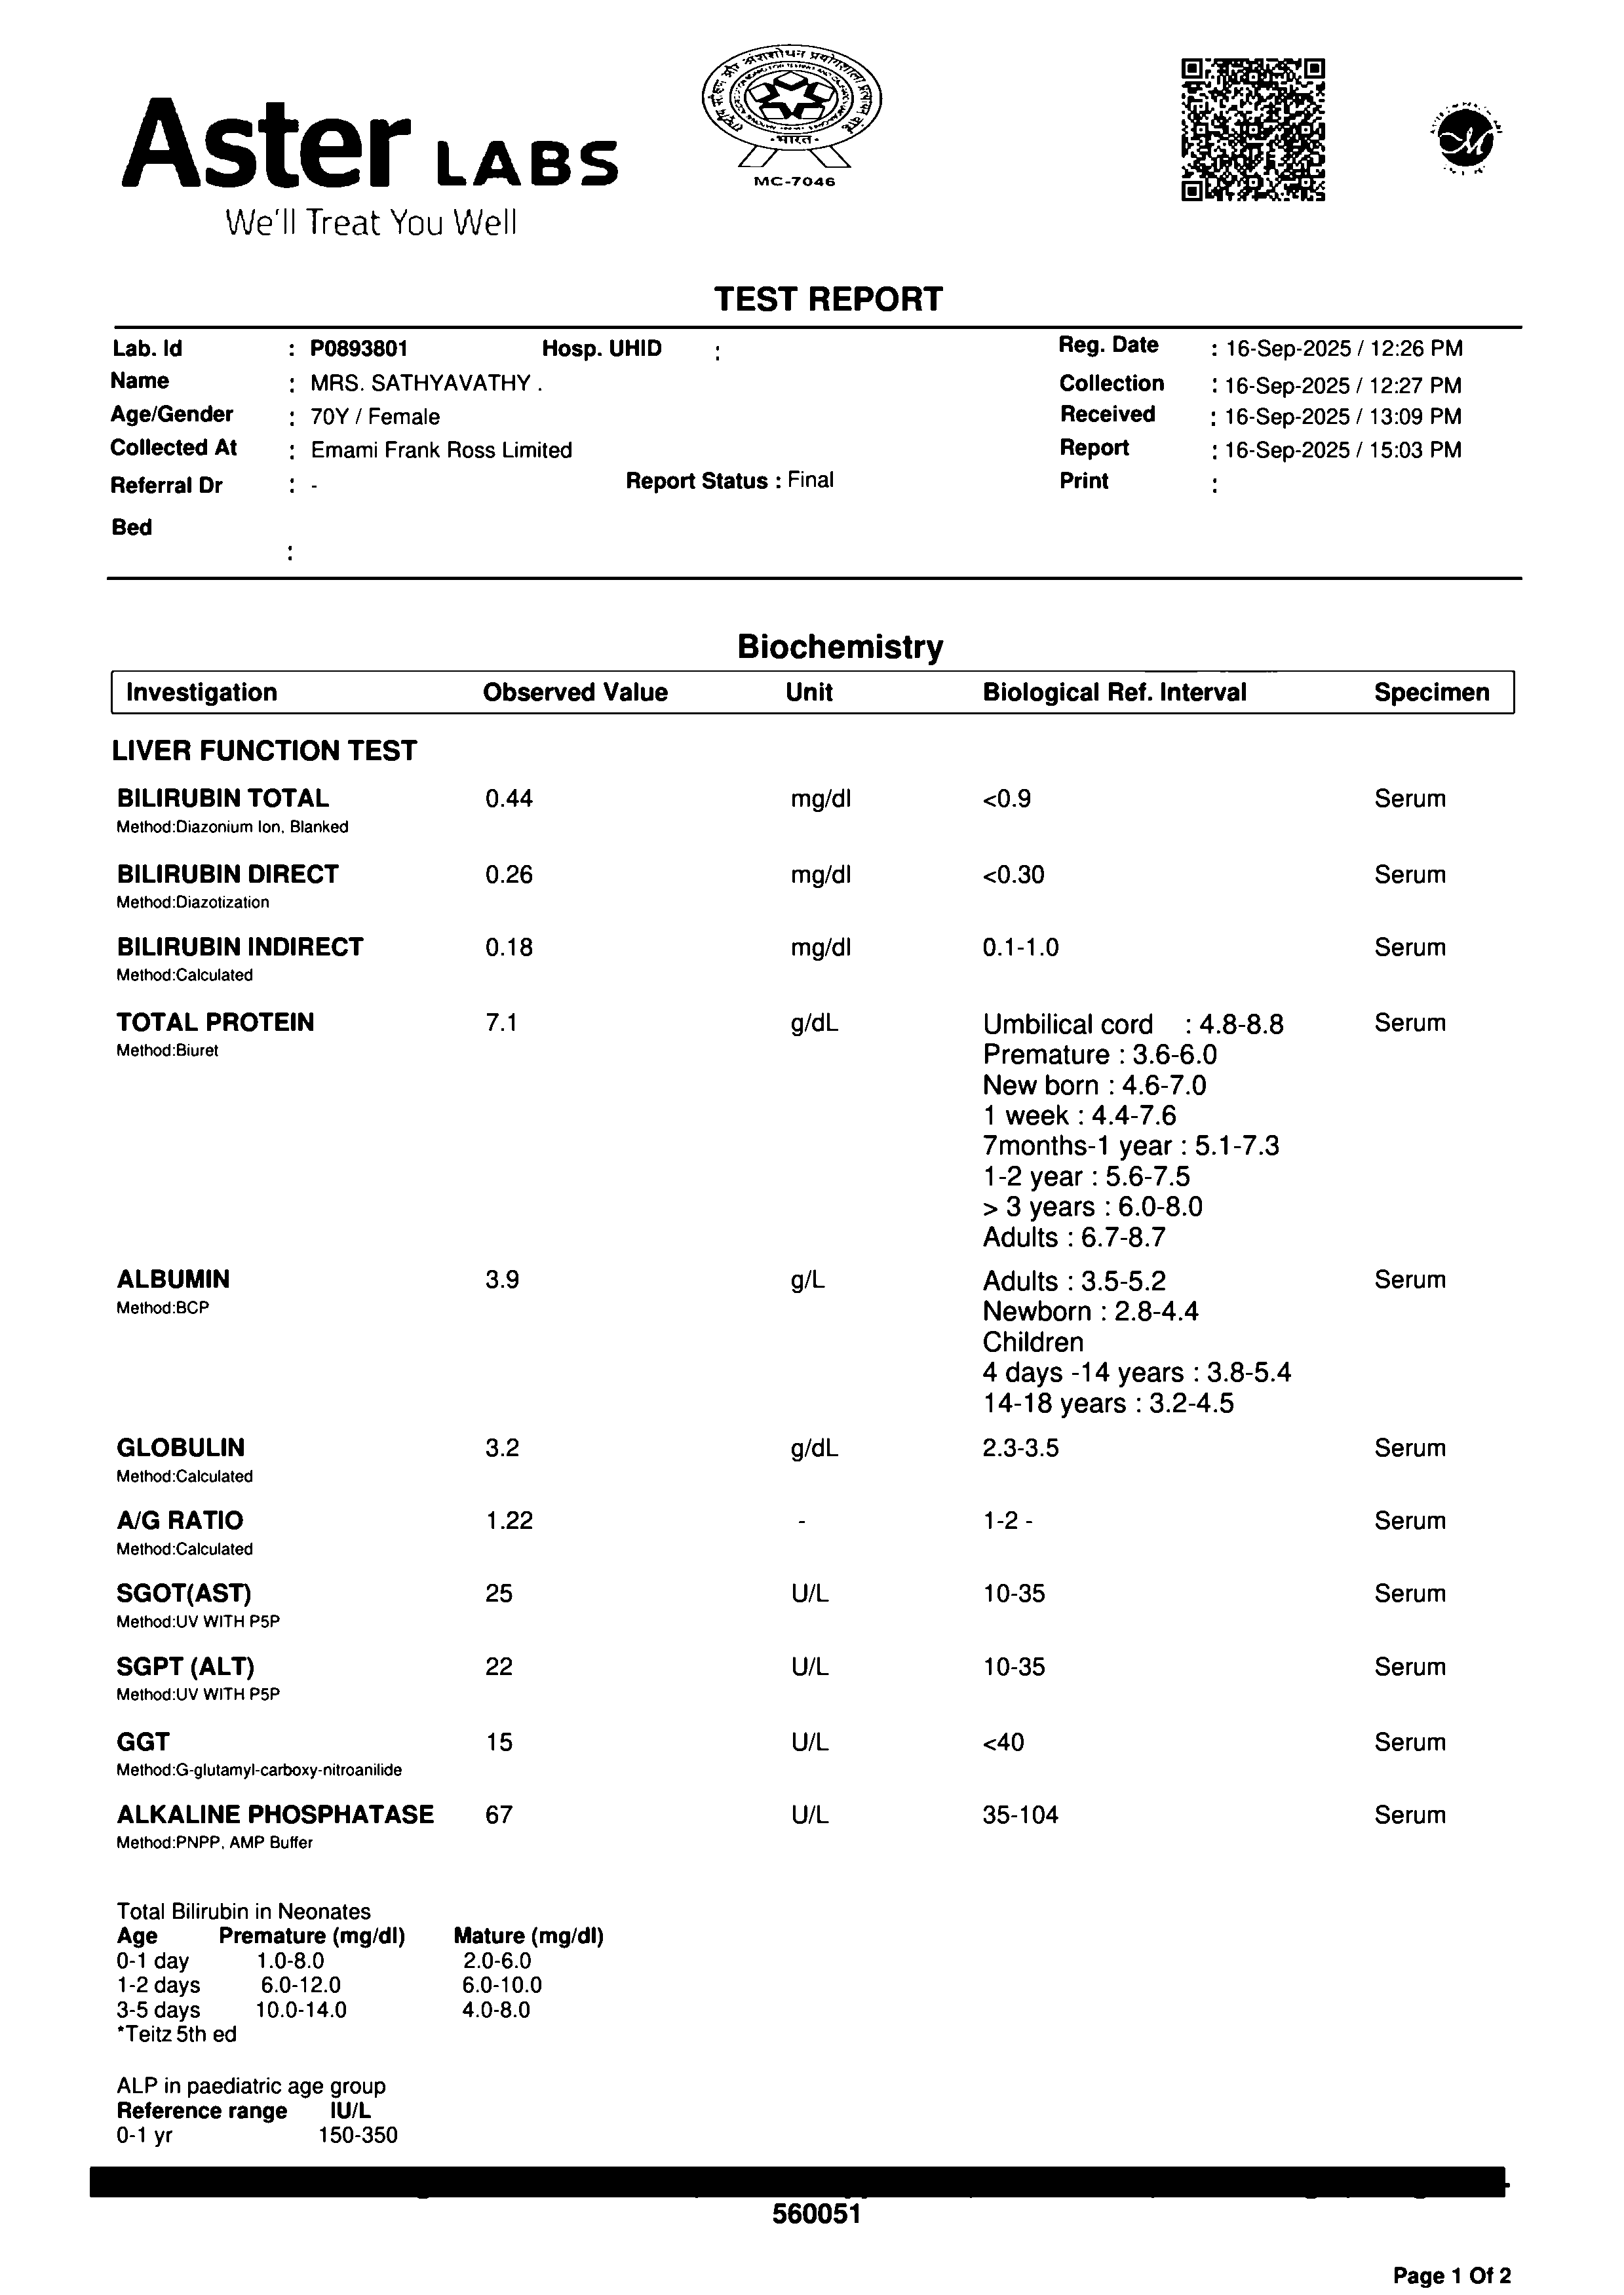

In [130]:
report_file_path = DUMMY_PDF_PATH
base_name = os.path.splitext(os.path.basename(report_file_path))[0]

if os.path.exists(report_file_path):
    cleaned_files = process_report_file(report_file_path, base_name)
    
    if cleaned_files:
        print(f"\n✅ Module 1 Success. Found {len(cleaned_files)} cleaned image(s).")
        print("Displaying the first cleaned image (Binary, Deskewed):")
        
        # Display the image in the notebook
        try:
            display_img = Image.open(cleaned_files[0])
            display(display_img)
        except Exception as e:
            print(f"Could not display image: {e}")
    else:
        print("❌ Module 1 Failed: Check file path and dependencies (PyMuPDF, Poppler).")
else:
    print("⚠️ Skipping Module 1 Test: Dummy PDF not found.")

# Module 2: OCR & Tokenisation 

In [131]:
def merge_close_tokens(tokens: list, max_gap: int = 20) -> list:
    """
    Merges adjacent tokens on the same horizontal line if the gap between them is small.
    This fixes fragmented names and compound words (e.g., "John" + "Doe" -> "John Doe").
    """
    if not tokens:
        return []
    
    merged_tokens = []
    current_phrase = tokens[0]
    
    for i in range(1, len(tokens)):
        next_token = tokens[i]
        
        # Calculate horizontal distance between tokens
        current_right = current_phrase['bbox']['left'] + current_phrase['bbox']['width']
        gap = next_token['bbox']['left'] - current_right
        
        # Check vertical alignment (y-overlap) and horizontal proximity
        y_overlap = abs(current_phrase['bbox']['top'] - next_token['bbox']['top'])
        
        # If the gap is small and they are vertically aligned (small y_overlap)
        if gap < max_gap and y_overlap < 5:
            # Merge: update text, width, and confidence (use min confidence)
            current_phrase['text'] += ' ' + next_token['text']
            current_phrase['bbox']['width'] += next_token['bbox']['width'] + gap
            current_phrase['conf'] = min(current_phrase['conf'], next_token['conf'])
        else:
            # Not mergeable, finalize the current phrase and start a new one
            merged_tokens.append(current_phrase)
            current_phrase = next_token
            
    merged_tokens.append(current_phrase)
    return merged_tokens

def run_ocr_and_tokenize(image_path: str, report_name: str) -> str:
    """Runs OCR on a cleaned image and saves word-level tokens with bboxes."""
    try:
        img_cv = cv2.imread(image_path)
        if img_cv is None:
            print(f"Error: Could not read image at {image_path}")
            return None

        # Use image_to_data to get word-level details (text, box, confidence)
        data = pytesseract.image_to_data(img_cv, output_type=pytesseract.Output.DICT)
        
        tokens_list = []
        n_boxes = len(data['level'])
        
        for i in range(n_boxes):
            # level 5 is word level
            if data['level'][i] == 5 and data['text'][i].strip():
                token = {
                    "text": data['text'][i],
                    "conf": float(data['conf'][i]) / 100, # Convert confidence to 0.0 to 1.0
                    "bbox": {
                        "left": data['left'][i],
                        "top": data['top'][i],
                        "width": data['width'][i],
                        "height": data['height'][i]
                    }
                }
                tokens_list.append(token)

        merged_tokens = merge_close_tokens(tokens_list)

        # Save tokens to a JSON file
        output_filename = f"{report_name}_tokens.json"
        output_path = os.path.join(TOKEN_DIR, output_filename)
        
        with open(output_path, 'w') as f:
            json.dump(merged_tokens, f, indent=4)
            
        print(f"Saved {len(merged_tokens)} tokens to: {output_path}")
        return output_path

    except Exception as e:
        print(f"❌ Module 2 Failed during OCR: {e}")
        return None


## Test Module 2

In [132]:
if 'cleaned_files' in locals() and cleaned_files:
    token_file_path = run_ocr_and_tokenize(cleaned_files[0], base_name)
    
    if token_file_path:
        with open(token_file_path, 'r') as f:
            tokens = json.load(f)
            
        print("\n✅ Module 2 Success. First 10 tokens extracted:")
        for token in tokens[:10]:
            print(f" - Text: '{token['text']}', Conf: {token['conf']:.2f}, BBox: {token['bbox']}")
    
else:
    print("⚠️ Skipping Module 2 Test: No cleaned image found from Module 1.")


Saved 175 tokens to: project_data\tokens\32187653_MRS. SATHYAVATHY_tokens.json

✅ Module 2 Success. First 70 tokens extracted:
 - Text: 'Aster', Conf: 0.92, BBox: {'left': 186, 'top': 149, 'width': 441, 'height': 138}
 - Text: 'tass', Conf: 0.48, BBox: {'left': 668, 'top': 215, 'width': 275, 'height': 68}
 - Text: 'We'll Treat You Well', Conf: 0.94, BBox: {'left': 345, 'top': 318, 'width': 441, 'height': 41}
 - Text: 'TEST REPORT', Conf: 0.96, BBox: {'left': 1090, 'top': 437, 'width': 349, 'height': 38}
 - Text: 'Lab. Id', Conf: 0.96, BBox: {'left': 174, 'top': 518, 'width': 103, 'height': 26}
 - Text: ':', Conf: 0.89, BBox: {'left': 442, 'top': 525, 'width': 6, 'height': 18}
 - Text: 'P0893801', Conf: 0.87, BBox: {'left': 475, 'top': 518, 'width': 144, 'height': 26}
 - Text: 'Hosp. UHID', Conf: 0.91, BBox: {'left': 829, 'top': 518, 'width': 180, 'height': 33}
 - Text: '‘', Conf: 0.49, BBox: {'left': 1093, 'top': 528, 'width': 4, 'height': 22}
 - Text: 'Reg. Date', Conf: 0.23, BBox: {'

# Module 3: Rule-Based Extraction (fast baseline) 

In [133]:
# import re
# from typing import Dict, List, Optional

# class RuleBasedExtractor:
#     """Extract structured data using regex patterns and heuristics"""
    
#     def __init__(self):
#         # Define regex patterns for common fields
#         self.patient_patterns = {
#             'name': [
#                 r'(?:Patient\s*)?Name[:\s]+([A-Za-z\s\.]+?)(?:\s{2,}|\n|Age|DOB|$)',
#                 r'Pt\.?\s*Name[:\s]+([A-Za-z\s\.]+?)(?:\s{2,}|\n|Age|DOB|$)',
#                 r'Name\s*:\s*([A-Za-z\s\.]+?)(?:\n|Age|DOB|$)',
#             ],
#             'age': [
#                 r'Age[:\s]+(\d+)',
#                 r'(\d+)\s*(?:yrs?|years?|Y)',
#                 r'Age\s*:\s*(\d+)',
#             ],
#             'patient_id': [
#                 r'(?:Patient\s*)?ID[:\s]+([A-Z0-9\-]+)',
#                 r'PID[:\s]+([A-Z0-9\-]+)',
#                 r'Patient\s*No[:\s]+([A-Z0-9\-]+)',
#             ],
#             'date': [
#                 r'Date[:\s]+(\d{1,2}[/-]\d{1,2}[/-]\d{2,4})',
#                 r'Report\s*Date[:\s]+(\d{1,2}[/-]\d{1,2}[/-]\d{2,4})',
#                 r'(\d{1,2}[/-]\d{1,2}[/-]\d{2,4})',
#             ],
#             'gender': [
#                 r'(?:Gender|Sex)[:\s]+(Male|Female|M|F)',
#                 r'(Male|Female)\s*(?:\n|Age|DOB)',
#             ]
#         }
        
#         # Common test name patterns
#         self.test_patterns = [
#             r'([A-Za-z\s\(\)]+?)\s+([\d\.]+)\s*([a-zA-Z/%μ]+)',
#             r'([A-Za-z\s]+):\s*([\d\.]+)\s*([a-zA-Z/%μ]+)?',
#         ]
    
#     def extract_patient_info(self, text: str) -> Dict[str, str]:
#         """Extract patient demographic information"""
#         info = {}
        
#         for field, patterns in self.patient_patterns.items():
#             for pattern in patterns:
#                 match = re.search(pattern, text, re.IGNORECASE | re.MULTILINE)
#                 if match:
#                     value = match.group(1).strip()
#                     # Clean up extra spaces
#                     value = re.sub(r'\s+', ' ', value)
#                     info[field] = value
#                     break  # Stop after first match
        
#         return info
    
#     def extract_test_results(self, text: str, tokens: List[Dict] = None) -> List[Dict]:
#         """Extract test results from text or tokens"""
#         tests = []
        
#         # Split text into lines
#         lines = text.split('\n')
        
#         for line in lines:
#             line = line.strip()
#             if not line:
#                 continue
            
#             # Try each test pattern
#             for pattern in self.test_patterns:
#                 match = re.search(pattern, line)
#                 if match:
#                     try:
#                         test_name = match.group(1).strip()
#                         test_value = float(match.group(2))
#                         test_unit = match.group(3).strip() if match.group(3) else ''
                        
#                         # Skip if test name is too short or looks like patient info
#                         if len(test_name) < 3:
#                             continue
#                         if any(skip in test_name.lower() for skip in ['name', 'age', 'date', 'gender']):
#                             continue
                        
#                         tests.append({
#                             'name': test_name,
#                             'value': test_value,
#                             'unit': test_unit,
#                             'confidence': 0.8  # Default confidence for rule-based
#                         })
#                         break  # Found match, move to next line
#                     except (ValueError, AttributeError):
#                         continue
        
#         return tests
    
#     def extract_reference_ranges(self, text: str) -> Dict[str, str]:
#         """Extract reference ranges if present"""
#         ranges = {}
        
#         # Pattern: Test Name: Value Unit (Range: X-Y Unit)
#         pattern = r'([A-Za-z\s]+).*?(?:Range|Normal)[:\s]+([\d\.]+-[\d\.]+\s*[a-zA-Z/%μ]*)'
        
#         matches = re.findall(pattern, text, re.IGNORECASE)
#         for test_name, range_val in matches:
#             ranges[test_name.strip()] = range_val.strip()
        
#         return ranges
    
#     def extract_all(self, text: str, tokens: List[Dict] = None) -> Dict:
#         """
#         Extract all structured information
        
#         Returns complete JSON structure
#         """
#         patient_info = self.extract_patient_info(text)
#         test_results = self.extract_test_results(text, tokens)
#         reference_ranges = self.extract_reference_ranges(text)
        
#         # Add reference ranges to tests if available
#         for test in test_results:
#             test_name = test['name']
#             if test_name in reference_ranges:
#                 test['reference_range'] = reference_ranges[test_name]
        
#         # Calculate overall confidence
#         if test_results:
#             avg_confidence = sum(t['confidence'] for t in test_results) / len(test_results)
#         else:
#             avg_confidence = 0.0
        
#         return {
#             'patient': patient_info,
#             'tests': test_results,
#             'metadata': {
#                 'extraction_method': 'rule_based',
#                 'overall_confidence': round(avg_confidence, 2),
#                 'num_tests_extracted': len(test_results)
#             }
#         }


In [134]:
# # Patterns for common patient fields
# PATIENT_PATTERNS = {
#     'name': [
#         r'(?:Patient\s*)?Name[:\s]+([A-Za-z\s\.]+?)(?:\s{2,}|\n|Age|DOB|$)',
#         r'Pt\.?\s*Name[:\s]+([A-Za-z\s\.]+?)(?:\s{2,}|\n|Age|DOB|$)',
#         r'Name\s*:\s*([A-Za-z\s\.]+?)(?:\n|Age|DOB|$)',
#     ],
#     'age': [
#         r'Age[:\s]+(\d+)',
#         r'(\d+)\s*(?:yrs?|years?|Y)\b',
#         r'Age\s*:\s*(\d+)',
#     ],
#     'patient_id': [
#         r'(?:Patient\s*)?ID[:\s]+([A-Z0-9\-]+)',
#         r'PID[:\s]+([A-Z0-9\-]+)',
#         r'Patient\s*No[:\s]+([A-Z0-9\-]+)',
#     ],
#     'date': [
#         r'Date[:\s]+(\d{1,2}[/-]\d{1,2}[/-]\d{2,4})',
#         r'Report\s*Date[:\s]+(\d{1,2}[/-]\d{1,2}[/-]\d{2,4})',
#     ],
#     'gender': [
#         r'(?:Gender|Sex)[:\s]+(Male|Female|M|F)',
#         r'(Male|Female)\s*(?:\n|Age|DOB)',
#     ]
# }

# # Patterns for test results (TestName Value Unit)
# TEST_PATTERNS = [
#     # Pattern 1: TestName Value Unit
#     r'([A-Za-z\s\(\)]+?)\s+([\d\.]+)\s*([a-zA-Z/%μ]+)',
#     # Pattern 2: TestName: Value [Unit]
#     r'([A-Za-z\s]+):\s*([\d\.]+)\s*([a-zA-Z/%μ]+)?',
# ]

# # Pattern for reference ranges
# REFERENCE_RANGE_PATTERN = r'([A-Za-z\s]+).*?(?:Range|Normal|Ref\s*Range)[:\s]+([\d\.]+-[\d\.]+\s*[a-zA-Z/%μ]*)'


# def group_tokens_into_lines(tokens: list, y_tolerance: int = 5) -> list:
#     """Groups tokens that are close vertically into lines."""
#     lines = []
#     current_line = []
    
#     # Sort tokens by Y-coordinate (top) then by X-coordinate (left)
#     sorted_tokens = sorted(tokens, key=lambda t: (t['bbox']['top'], t['bbox']['left']))

#     for token in sorted_tokens:
#         if not current_line:
#             current_line.append(token)
#             continue

#         # Check if the token's top is close to the average top of the current line
#         avg_top = np.mean([t['bbox']['top'] for t in current_line])
#         if abs(token['bbox']['top'] - avg_top) < y_tolerance:
#             current_line.append(token)
#         else:
#             lines.append(current_line)
#             current_line = [token]
    
#     if current_line:
#         lines.append(current_line)
        
#     # Join tokens in each line back into a single text string
#     text_lines = [" ".join(t['text'] for t in line) for line in lines]
#     return text_lines

# def extract_patient_info(full_text: str) -> Dict[str, str]:
#     """Extract patient demographic information using multiple regex patterns."""
#     info = {}
    
#     for field, patterns in PATIENT_PATTERNS.items():
#         for pattern in patterns:
#             # Use MULTILINE flag for comprehensive search across the whole text block
#             match = re.search(pattern, full_text, re.IGNORECASE | re.MULTILINE)
#             if match:
#                 value = match.group(1).strip()
#                 # Clean up extra spaces
#                 value = re.sub(r'\s+', ' ', value)
#                 info[field] = value
#                 break  # Stop after first successful match for this field
                
#     return info

# def extract_test_results(text_lines: list) -> List[Dict]:
#     """Extract test results (Name, Value, Unit) from text lines."""
#     tests = []
    
#     for line in text_lines:
#         line = line.strip()
#         if not line:
#             continue
        
#         for pattern in TEST_PATTERNS:
#             match = re.search(pattern, line)
#             if match:
#                 try:
#                     test_name = match.group(1).strip()
#                     test_value = float(match.group(2))
#                     # Group 3 is optional (unit)
#                     test_unit = match.group(3).strip() if len(match.groups()) >= 3 and match.group(3) else ''
                    
#                     # Skip if test name is too short or looks like patient info
#                     if len(test_name) < 3:
#                         continue
#                     if any(skip in test_name.lower() for skip in ['name', 'age', 'date', 'gender', 'id']):
#                         continue
                        
#                     tests.append({
#                         'name': test_name,
#                         'value': test_value,
#                         'unit': test_unit,
#                         'confidence_rule': 0.8  # Default confidence
#                     })
#                     break  # Found match, move to next line
#                 except (ValueError, AttributeError):
#                     continue
                    
#     return tests

# def extract_reference_ranges(full_text: str) -> Dict[str, str]:
#     """Extracts reference ranges and maps them to test names."""
#     ranges = {}
    
#     matches = re.findall(REFERENCE_RANGE_PATTERN, full_text, re.IGNORECASE)
#     for test_name, range_val in matches:
#         ranges[test_name.strip()] = range_val.strip()
        
#     return ranges


# def extract_preliminary_data(tokens: list) -> dict:
#     """Uses Regex and heuristics to extract patient info and test results from tokens."""
    
#     text_lines = group_tokens_into_lines(tokens)
#     full_text = "\n".join(text_lines)
    
#     # 1. Extract Patient Info
#     patient_info = extract_patient_info(full_text)
    
#     # 2. Extract Test Results
#     test_results = extract_test_results(text_lines)
    
#     # 3. Extract Reference Ranges
#     reference_ranges = extract_reference_ranges(full_text)
    
#     # 4. Merge Ranges into Tests
#     for test in test_results:
#         test_name = test['name']
#         if test_name in reference_ranges:
#             test['reference_range'] = reference_ranges[test_name]
            
#     data = {
#         "patient": patient_info,
#         "tests": test_results,
#         "metadata": {
#             "extraction_method": "rule_based",
#             "num_tests_extracted": len(test_results),
#             "overall_confidence": 0.8 # Placeholder until ML confidence is merged
#         }
#     }
                
#     return data

In [135]:
# import re
# import numpy as np
# import json
# from typing import Dict, List, Optional, Tuple

# # --- Configuration and Patterns for Module 3 ---

# PATIENT_PATTERNS = {
#     'name': [
#         r'(?:Patient\s*)?Name[:\s]+([A-Za-z\s\.]+?)(?:\s{2,}|\n|Age|DOB|$)',
#         r'Pt\.?\s*Name[:\s]+([A-Za-z\s\.]+?)(?:\s{2,}|\n|Age|DOB|$)',
#         r'Name\s*:\s*([A-Za-z\s\.]+?)(?:\n|Age|DOB|$)',
#         r'Name\s*:?\s*(MR\.?|MRS\.?|MS\.?|MISS\.?)\s*([A-Za-z\s\.]+?)(?:\s{2,}|\n|Age|DOB|$)',
#     ],
#     'age': [
#         r'Age[/]?Gender[:\s]+(\d+)\s*(?:yrs?|years?|Y)',
#         r'Age[:\s]+(\d+)',
#     ],
#     'patient_id': [
#         r'(?:Lab\s*No\.?|Lab\.?\s*Id)[:\s]+([A-Z0-9\-]+)',
#         r'(?:Patient\s*)?ID[:\s]+([A-Z0-9\-]+)',
#     ],
#     'date': [
#         r'(?:Reg|Report|Collected)\s*Date[:\s]*(?:and\s*Time)?[:\s]+(\d{1,2}[/-]\d{1,2}[/-]\d{2,4})',
#     ],
#     'gender': [
#         r'(?:Age[/])?Gender[:\s]+.*?(Male|Female|M|F)\b',
#         r'(?:Gender|Sex)[:\s]+(Male|Female|M|F)',
#     ]
# }

# REFERENCE_RANGE_PATTERN = r'([A-Za-z\s()]+)\s*.*?((?:Range|Normal|Ref\s*Interval)[:\s]+[\d\.\-]+\s*[\d\.\-]+\s*[a-zA-Z/%μµ]*)'

# # --- Core Helper Functions ---

# def group_tokens_into_lines(tokens: list, y_tolerance: int = 8) -> Tuple[list[str], list[list[Dict]]]:
#     """Groups tokens that are close vertically into lines."""
#     lines = []
#     current_line = []
    
#     # Sort tokens by Y-coordinate (top) then by X-coordinate (left)
#     sorted_tokens = sorted(tokens, key=lambda t: (t['bbox']['top'], t['bbox']['left']))

#     for token in sorted_tokens:
#         if not current_line:
#             current_line.append(token)
#             continue

#         avg_top = np.mean([t['bbox']['top'] for t in current_line])
        
#         if abs(token['bbox']['top'] - avg_top) < y_tolerance:
#             current_line.append(token)
#         else:
#             lines.append(current_line)
#             current_line = [token]
    
#     if current_line:
#         lines.append(current_line)
        
#     text_lines = [" ".join(t['text'] for t in line) for line in lines]
#     return text_lines, lines


# def extract_patient_info(full_text: str) -> Dict[str, str]:
#     """Extract patient demographic information using multiple regex patterns."""
#     info = {}
    
#     for field, patterns in PATIENT_PATTERNS.items():
#         for pattern in patterns:
#             match = re.search(pattern, full_text, re.IGNORECASE | re.MULTILINE)
#             if match:
#                 # Use group 2 if available (to strip titles like MR./MRS.)
#                 if field == 'name' and len(match.groups()) > 1 and match.group(2) is not None:
#                     value = match.group(2).strip()
#                 else:
#                     value = match.group(1).strip()

#                 value = re.sub(r'\s+', ' ', value)
#                 info[field] = value
#                 break
                
#     return info


# def cluster_centers(centers: List[float], tolerance: int = 25) -> List[float]:
#     """Clusters X-coordinates to find consistent column alignments."""
#     if not centers: return []
#     clusters = []
#     centers.sort()
    
#     for center in centers:
#         found = False
#         for cluster in clusters:
#             if abs(center - cluster['center']) < tolerance:
#                 cluster['centers'].append(center)
#                 cluster['center'] = np.mean(cluster['centers'])
#                 found = True
#                 break
#         if not found:
#             clusters.append({'center': center, 'centers': [center]})
    
#     # Only return the centers of robust clusters (heuristic: require at least 15 points)
#     return [c['center'] for c in clusters if len(c['centers']) > 15] 


# def extract_test_results_from_tokens(structured_lines: List[List[Dict]]) -> List[Dict]:
#     """
#     Extract test results (Name, Value, Unit) using the Column Alignment Heuristic.
#     """
#     tests = []
#     value_centers, unit_centers = [], []
    
#     # 1. Gather all potential Value and Unit centers across the entire page
#     for line_tokens in structured_lines:
#         for token in line_tokens:
#             x_center = token['bbox']['left'] + token['bbox']['width'] / 2
#             is_numeric = re.match(r'^-?[\d,]+(\.\d+)?$', token['text'].replace(',', ''))
#             is_unit = re.match(r'^[a-zA-Z/%μµ\(\)]+(/[a-zA-Z\d]+)?$', token['text']) and len(token['text']) < 10

#             if is_numeric:
#                 value_centers.append(x_center)
#             elif is_unit:
#                 unit_centers.append(x_center)

#     # 2. Determine the most probable columns for VALUE and UNIT
#     PROBABLE_VALUE_X = cluster_centers(value_centers)
#     PROBABLE_UNIT_X = cluster_centers(unit_centers)
    
#     if not PROBABLE_VALUE_X:
#         print("Warning: No clear Value column detected.")
#         return [] 
    
#     # 3. Iterate through lines and extract data based on column alignment
#     for line_tokens in structured_lines:
#         test_name_tokens = []
        
#         for i, token in enumerate(line_tokens):
#             x_center = token['bbox']['left'] + token['bbox']['width'] / 2
#             is_numeric = re.match(r'^-?[\d,]+(\.\d+)?$', token['text'].replace(',', ''))
            
#             # Check for value alignment and numeric content
#             is_value_aligned = any(abs(x_center - x) < 30 for x in PROBABLE_VALUE_X)

#             if is_value_aligned and is_numeric:
                
#                 # Test Name: Combine all non-empty tokens to the left
#                 test_name = " ".join(t['text'] for t in test_name_tokens).strip()
                
#                 # Unit: Look for the next aligned token in the UNIT column
#                 test_unit = ""
#                 for next_token in line_tokens[i+1:]:
#                     next_x_center = next_token['bbox']['left'] + next_token['bbox']['width'] / 2
#                     is_unit_aligned = any(abs(next_x_center - x) < 30 for x in PROBABLE_UNIT_X)
                    
#                     # We only accept a unit if it aligns with a unit column AND looks like a unit
#                     is_unit = re.match(r'^[a-zA-Z/%μµ\(\)]+(/[a-zA-Z\d]+)?$', next_token['text']) and len(next_token['text']) < 10
                    
#                     if is_unit_aligned and is_unit:
#                         test_unit = next_token['text']
#                         break
                        
#                 # Validation & Append (Filter out headers or junk names)
#                 if len(test_name) > 3 and not any(skip in test_name.lower() for skip in ['name', 'test name', 'results', 'units', 'bio. ref. interval', 'method', 'calculated']):
#                     try:
#                         tests.append({
#                             'name': re.sub(r'[.:;]$', '', test_name), 
#                             'value': float(token['text'].replace(',', '')), 
#                             'unit': test_unit,
#                             'confidence_rule': token['conf']
#                         })
#                     except ValueError:
#                         # Should not happen if regex matched, but safety catch
#                         pass
                
#                 # Found the test result for this line, break the inner loop
#                 break 

#             elif not is_value_aligned and not is_numeric:
#                 # If it's not a value and not a number, it's a candidate for the test name
#                 test_name_tokens.append(token)
                
#     return tests


# def extract_reference_ranges(full_text: str) -> Dict[str, str]:
#     """Extracts reference ranges and maps them to test names."""
#     ranges = {}
#     pattern = r'([A-Za-z\s()]+)\s*.*?((?:Range|Normal|Ref\s*Interval)[:\s]+[\d\.\-]+\s*[\d\.\-]+\s*[a-zA-Z/%μµ]*)'

#     matches = re.findall(pattern, full_text, re.IGNORECASE | re.MULTILINE)
#     for test_name, range_val in matches:
#         # Clean test name: remove methods, calculation notes, and trailing symbols
#         test_name = re.sub(r'\s*(?:Method|Calculated).*$', '', test_name, flags=re.IGNORECASE).strip()
#         test_name = re.sub(r'[.:;]$', '', test_name).strip()
#         if len(test_name) > 3 and not any(skip in test_name.lower() for skip in ['test', 'investigation', 'note']):
#             ranges[test_name] = range_val.strip()
        
#     return ranges


# def extract_preliminary_data(tokens: list) -> dict:
#     """Combines all rule-based extraction steps."""
    
#     # 1. Group tokens by line and get full text
#     text_lines, structured_lines = group_tokens_into_lines(tokens)
#     full_text = "\n".join(text_lines)
    
#     # 2. Extract Data
#     patient_info = extract_patient_info(full_text)
#     test_results = extract_test_results_from_tokens(structured_lines)
#     reference_ranges = extract_reference_ranges(full_text)
    
#     # 3. Merge Ranges into Tests
#     for test in test_results:
#         test_name = test['name']
#         range_key = next((k for k in reference_ranges if k.lower() == test_name.lower()), None)
#         if range_key:
#             test['reference_range'] = reference_ranges[range_key]
            
#     data = {
#         "patient": patient_info,
#         "tests": test_results,
#         "metadata": {
#             "extraction_method": "rule_based_enhanced_column_align",
#             "num_tests_extracted": len(test_results),
#             "overall_confidence": np.mean([t['confidence_rule'] for t in test_results]) if test_results else 0.0
#         }
#     }
#     return data

In [136]:
# import re
# import numpy as np
# import json
# from typing import Dict, List, Optional, Tuple

# # --- Configuration and Patterns for Module 3 ---

# PATIENT_PATTERNS = {
#     'name': [
#         r'(?:Patient\s*)?Name[:\s]+([A-Za-z\s\.]+?)(?:\s{2,}|\n|Age|DOB|$)',
#         r'Pt\.?\s*Name[:\s]+([A-Za-z\s\.]+?)(?:\s{2,}|\n|Age|DOB|$)',
#         r'Name\s*:\s*([A-Za-z\s\.]+?)(?:\n|Age|DOB|$)',
#         r'Name\s*:?\s*(MR\.?|MRS\.?|MS\.?|MISS\.?)\s*([A-Za-z\s\.]+?)(?:\s{2,}|\n|Age|DOB|$)',
#     ],
#     'age': [
#         r'Age[/]?Gender[:\s]+(\d+)\s*(?:yrs?|years?|Y)',
#         r'Age[:\s]+(\d+)',
#     ],
#     'patient_id': [
#         r'(?:Lab\s*No\.?|Lab\.?\s*Id)[:\s]+([A-Z0-9\-]+)',
#         r'(?:Patient\s*)?ID[:\s]+([A-Z0-9\-]+)',
#     ],
#     'date': [
#         r'(?:Reg|Report|Collected)\s*Date[:\s]*(?:and\s*Time)?[:\s]+(\d{1,2}[/-]\d{1,2}[/-]\d{2,4})',
#     ],
#     'gender': [
#         r'(?:Age[/])?Gender[:\s]+.*?(Male|Female|M|F)\b',
#         r'(?:Gender|Sex)[:\s]+(Male|Female|M|F)',
#     ]
# }

# REFERENCE_RANGE_PATTERN = r'([A-Za-z\s()]+)\s*.*?((?:Range|Normal|Ref\s*Interval)[:\s]+[\d\.\-]+\s*[\d\.\-]+\s*[a-zA-Z/%μµ]*)'

# # --- Core Helper Functions ---

# def group_tokens_into_lines(tokens: list, y_tolerance: int = 8) -> Tuple[list[str], list[list[Dict]]]:
#     """Groups tokens that are close vertically into lines."""
#     lines = []
#     current_line = []
    
#     sorted_tokens = sorted(tokens, key=lambda t: (t['bbox']['top'], t['bbox']['left']))

#     for token in sorted_tokens:
#         if not current_line:
#             current_line.append(token)
#             continue

#         avg_top = np.mean([t['bbox']['top'] for t in current_line])
        
#         if abs(token['bbox']['top'] - avg_top) < y_tolerance:
#             current_line.append(token)
#         else:
#             lines.append(current_line)
#             current_line = [token]
    
#     if current_line:
#         lines.append(current_line)
        
#     text_lines = [" ".join(t['text'] for t in line) for line in lines]
#     return text_lines, lines


# def extract_patient_info(full_text: str) -> Dict[str, str]:
#     """Extract patient demographic information using multiple regex patterns."""
#     info = {}
    
#     for field, patterns in PATIENT_PATTERNS.items():
#         for pattern in patterns:
#             match = re.search(pattern, full_text, re.IGNORECASE | re.MULTILINE)
#             if match:
#                 if field == 'name' and len(match.groups()) > 1 and match.group(2) is not None:
#                     value = match.group(2).strip()
#                 else:
#                     value = match.group(1).strip()

#                 value = re.sub(r'\s+', ' ', value)
#                 info[field] = value
#                 break
                
#     return info


# def cluster_centers(centers: List[float], tolerance: int = 20, min_points: int = 5) -> List[float]:
#     """
#     Clusters X-coordinates to find consistent column alignments.
#     Reduced tolerance and min_points for better results on sparse data.
#     """
#     if not centers: return []
#     clusters = []
#     centers.sort()
    
#     for center in centers:
#         found = False
#         for cluster in clusters:
#             if abs(center - cluster['center']) < tolerance:
#                 cluster['centers'].append(center)
#                 cluster['center'] = np.mean(cluster['centers'])
#                 found = True
#                 break
#         if not found:
#             clusters.append({'center': center, 'centers': [center]})
    
#     # Only return the centers of robust clusters (at least min_points)
#     return [c['center'] for c in clusters if len(c['centers']) >= min_points] 


# def extract_test_results_from_tokens(structured_lines: List[List[Dict]]) -> List[Dict]:
#     """
#     Extract test results (Name, Value, Unit) using the Column Alignment Heuristic.
#     """
#     tests = []
#     value_centers, unit_centers = [], []
    
#     # 1. Gather all potential Value and Unit centers across the entire page
#     for line_tokens in structured_lines:
#         for token in line_tokens:
#             x_center = token['bbox']['left'] + token['bbox']['width'] / 2
#             is_numeric = re.match(r'^-?[\d,]+(\.\d+)?$', token['text'].replace(',', ''))
#             is_unit = re.match(r'^[a-zA-Z/%μµ\(\)]+(/[a-zA-Z\d]+)?$', token['text']) and len(token['text']) < 10

#             # Filter out known junk values (like the Lab ID/Pt ID on the top half of the report)
#             if token['bbox']['top'] > 1000: # Heuristic: Start looking for results only below a certain Y-coordinate
#                 if is_numeric:
#                     value_centers.append(x_center)
#                 elif is_unit:
#                     unit_centers.append(x_center)

#     # 2. Determine the most probable columns for VALUE and UNIT
#     PROBABLE_VALUE_X = cluster_centers(value_centers, tolerance=25, min_points=5) # Reduced threshold
#     PROBABLE_UNIT_X = cluster_centers(unit_centers, tolerance=25, min_points=5) # Reduced threshold
    
#     if not PROBABLE_VALUE_X:
#         # print("Warning: No clear Value column detected.") # Suppress warning for clean output
#         return [] 
    
#     # 3. Iterate through lines and extract data based on column alignment
#     for line_tokens in structured_lines:
#         test_name_tokens = []
        
#         # Heuristic: Skip processing header lines explicitly
#         if line_tokens and line_tokens[0]['bbox']['top'] < 1000:
#              continue
        
#         for i, token in enumerate(line_tokens):
#             x_center = token['bbox']['left'] + token['bbox']['width'] / 2
#             is_numeric = re.match(r'^-?[\d,]+(\.\d+)?$', token['text'].replace(',', ''))
            
#             # Check for value alignment and numeric content
#             is_value_aligned = any(abs(x_center - x) < 30 for x in PROBABLE_VALUE_X)

#             if is_value_aligned and is_numeric:
                
#                 # Test Name: Combine all non-empty tokens to the left
#                 test_name = " ".join(t['text'] for t in test_name_tokens).strip()
                
#                 # Unit: Look for the next aligned token in the UNIT column
#                 test_unit = ""
#                 for next_token in line_tokens[i+1:]:
#                     next_x_center = next_token['bbox']['left'] + next_token['bbox']['width'] / 2
#                     is_unit_aligned = any(abs(next_x_center - x) < 30 for x in PROBABLE_UNIT_X)
                    
#                     is_unit = re.match(r'^[a-zA-Z/%μµ\(\)]+(/[a-zA-Z\d]+)?$', next_token['text']) and len(next_token['text']) < 10
                    
#                     if is_unit_aligned and is_unit:
#                         test_unit = next_token['text']
#                         break
                        
#                 # Validation & Append (Filter out non-test names)
#                 if len(test_name) > 3 and not any(skip in test_name.lower() for skip in ['name', 'test name', 'results', 'units', 'bio. ref. interval', 'method', 'calculated', 'abnormal', 'summary']):
#                     try:
#                         tests.append({
#                             'name': re.sub(r'[.:;]$', '', test_name), 
#                             'value': float(token['text'].replace(',', '')), 
#                             'unit': test_unit,
#                             'confidence_rule': token['conf']
#                         })
#                     except ValueError:
#                         pass
                
#                 break 

#             elif not is_value_aligned and not is_numeric and token['text'].strip():
#                 # If it's not a value AND not a number, AND is not empty, it's a candidate for the test name
#                 test_name_tokens.append(token)
                
#     return tests


# def extract_reference_ranges(full_text: str) -> Dict[str, str]:
#     """Extracts reference ranges and maps them to test names."""
#     ranges = {}
#     pattern = r'([A-Za-z\s()]+)\s*.*?((?:Range|Normal|Ref\s*Interval)[:\s]+[\d\.\-]+\s*[\d\.\-]+\s*[a-zA-Z/%μµ]*)'

#     matches = re.findall(pattern, full_text, re.IGNORECASE | re.MULTILINE)
#     for test_name, range_val in matches:
#         test_name = re.sub(r'\s*(?:Method|Calculated).*$', '', test_name, flags=re.IGNORECASE).strip()
#         test_name = re.sub(r'[.:;]$', '', test_name).strip()
#         if len(test_name) > 3 and not any(skip in test_name.lower() for skip in ['test', 'investigation', 'note']):
#             ranges[test_name] = range_val.strip()
        
#     return ranges


# def extract_preliminary_data(tokens: list) -> dict:
#     """Combines all rule-based extraction steps."""
    
#     # 1. Group tokens by line and get full text
#     text_lines, structured_lines = group_tokens_into_lines(tokens)
#     full_text = "\n".join(text_lines)
    
#     # 2. Extract Data
#     patient_info = extract_patient_info(full_text)
#     test_results = extract_test_results_from_tokens(structured_lines)
#     reference_ranges = extract_reference_ranges(full_text)
    
#     # 3. Merge Ranges into Tests
#     for test in test_results:
#         test_name = test['name']
#         range_key = next((k for k in reference_ranges if k.lower() == test_name.lower()), None)
#         if range_key:
#             test['reference_range'] = reference_ranges[range_key]
            
#     data = {
#         "patient": patient_info,
#         "tests": test_results,
#         "metadata": {
#             "extraction_method": "rule_based_enhanced_column_align",
#             "num_tests_extracted": len(test_results),
#             "overall_confidence": np.mean([t['confidence_rule'] for t in test_results]) if test_results else 0.0
#         }
#     }
#     return data

In [137]:
# import re
# import numpy as np
# import json
# from typing import Dict, List, Optional, Tuple

# # --- Configuration and Patterns for Module 3 (Same as before) ---

# PATIENT_PATTERNS = {
#     # Added negative keywords common in the Aster report
#     'name': [
#         r'(?:Patient\s*)?Name[:\s]+([A-Za-z\s\.]+?)(?:\s{2,}|\n|Age|DOB|Collected|$)', # Added Collected
#         r'Pt\.?\s*Name[:\s]+([A-Za-z\s\.]+?)(?:\s{2,}|\n|Age|DOB|Collected|$)',
#         r'Name\s*:\s*([A-Za-z\s\.]+?)(?:\n|Age|DOB|Collected|$)',
#         r'Name\s*:?\s*(MR\.?|MRS\.?|MS\.?|MISS\.?)\s*([A-Za-z\s\.]+?)(?:\s{2,}|\n|Age|DOB|Collected|$)',
#     ],
#     'age': [
#         r'Age[/]?Gender[:\s]+(\d+)\s*(?:yrs?|years?|Y)',
#         r'Age[:\s]+(\d+)',
#     ],
#     'patient_id': [
#         r'(?:Lab\s*No\.?|Lab\.?\s*Id)[:\s]+([A-Z0-9\-]+)',
#         r'(?:Patient\s*)?ID[:\s]+([A-Z0-9\-]+)',
#     ],
#     'date': [
#         r'(?:Reg|Report|Collected)\s*Date[:\s]*(?:and\s*Time)?[:\s]+(\d{1,2}[/-]\d{1,2}[/-]\d{2,4})',
#     ],
#     'gender': [
#         r'(?:Age[/])?Gender[:\s]+.*?(Male|Female|M|F)\b',
#         r'(?:Gender|Sex)[:\s]+(Male|Female|M|F)',
#     ]
# }

# REFERENCE_RANGE_PATTERN = r'([A-Za-z\s()]+)\s*.*?((?:Range|Normal|Ref\s*Interval)[:\s]+[\d\.\-]+\s*[\d\.\-]+\s*[a-zA-Z/%μµ]*)'

# # --- Core Helper Functions (Refined) ---

# def group_tokens_into_lines(tokens: list, y_tolerance: int = 8) -> Tuple[list[str], list[list[Dict]]]:
#     """Groups tokens that are close vertically into lines."""
#     lines = []
#     current_line = []
#     sorted_tokens = sorted(tokens, key=lambda t: (t['bbox']['top'], t['bbox']['left']))

#     for token in sorted_tokens:
#         if not current_line:
#             current_line.append(token)
#             continue
#         avg_top = np.mean([t['bbox']['top'] for t in current_line])
#         if abs(token['bbox']['top'] - avg_top) < y_tolerance:
#             current_line.append(token)
#         else:
#             lines.append(current_line)
#             current_line = [token]
    
#     if current_line:
#         lines.append(current_line)
        
#     text_lines = [" ".join(t['text'] for t in line) for line in lines]
#     return text_lines, lines


# def extract_patient_info(full_text: str) -> Dict[str, str]:
#     """Extract patient demographic information using multiple regex patterns with negative filtering."""
#     info = {}
    
#     # Negative lookahead for table headers that match the generic pattern
#     NEGATIVE_LOOKAHEAD = r'(?!.*(?:Test Name|Result Value|Unit|Reference Range|Abnormal|Summary|Collection|Investigation))'
    
#     for field, patterns in PATIENT_PATTERNS.items():
#         for pattern_base in patterns:
#             # Inject negative lookahead before the value capture group
#             pattern = pattern_base.replace(r'(.+?)', NEGATIVE_LOOKAHEAD + r'(.+?)')
            
#             match = re.search(pattern, full_text, re.IGNORECASE | re.MULTILINE)
#             if match:
#                 if field == 'name' and len(match.groups()) > 1 and match.group(2) is not None:
#                     value = match.group(2).strip()
#                 else:
#                     value = match.group(1).strip()
                
#                 value = re.sub(r'\s+', ' ', value)
#                 info[field] = value
#                 break
                
#     return info


# def cluster_centers(centers: List[float], tolerance: int = 25, min_points: int = 5) -> List[float]:
#     """Clusters X-coordinates to find consistent column alignments."""
#     if not centers: return []
#     clusters = []
#     centers.sort()
    
#     for center in centers:
#         found = False
#         for cluster in clusters:
#             if abs(center - cluster['center']) < tolerance:
#                 cluster['centers'].append(center)
#                 cluster['center'] = np.mean(cluster['centers'])
#                 found = True
#                 break
#         if not found:
#             clusters.append({'center': center, 'centers': [center]})
    
#     return [c['center'] for c in clusters if len(c['centers']) >= min_points] 


# def extract_test_results_from_tokens(structured_lines: List[List[Dict]]) -> List[Dict]:
#     """
#     Extract test results (Name, Value, Unit) using the Column Alignment Heuristic,
#     with tighter control over the Test Name boundary.
#     """
#     tests = []
#     value_centers, unit_centers = [], []
    
#     # Heuristic Barrier: The result/unit columns generally start well after the Test Name column
#     # Based on the Aster report: Test Name ends ~450-500. Value starts ~740. Unit starts ~1200.
#     VALUE_START_X_BARRIER = 700 
    
#     # 1. Gather all potential Value and Unit centers across the entire page (Y > 1100, past the main header)
#     for line_tokens in structured_lines:
#         for token in line_tokens:
#             if token['bbox']['top'] < 1100: continue # Skip all header lines
#             x_center = token['bbox']['left'] + token['bbox']['width'] / 2
            
#             is_numeric = re.match(r'^-?[\d,]+(\.\d+)?$', token['text'].replace(',', ''))
#             is_unit = re.match(r'^[a-zA-Z/%μµ\(\)]+(/[a-zA-Z\d]+)?$', token['text']) and len(token['text']) < 10

#             # CRITICAL FILTER: Only consider tokens to the right of the expected data start barrier
#             if x_center > VALUE_START_X_BARRIER:
#                 if is_numeric:
#                     value_centers.append(x_center)
#                 elif is_unit:
#                     unit_centers.append(x_center)

#     # 2. Determine the most probable columns for VALUE and UNIT
#     PROBABLE_VALUE_X = cluster_centers(value_centers, min_points=5)
#     PROBABLE_UNIT_X = cluster_centers(unit_centers, min_points=5)
    
#     # --- DEBUGGING OUTPUT START (Refined Clustering) ---
#     print(f"\n[DEBUG] Post-Filter Value Centers Found: {len(value_centers)}")
#     print(f"[DEBUG] Clustered Value Columns (Centers): {[round(x) for x in PROBABLE_VALUE_X]}")
#     print(f"[DEBUG] Clustered Unit Columns (Centers): {[round(x) for x in PROBABLE_UNIT_X]}")
#     # --- DEBUGGING OUTPUT END ---
    
#     if not PROBABLE_VALUE_X: return [] 
    
#     # 3. Iterate through lines and extract data based on column alignment
#     for line_tokens in structured_lines:
#         test_name_tokens = []
#         if line_tokens and line_tokens[0]['bbox']['top'] < 1100: continue
        
#         for i, token in enumerate(line_tokens):
#             x_center = token['bbox']['left'] + token['bbox']['width'] / 2
#             is_numeric = re.match(r'^-?[\d,]+(\.\d+)?$', token['text'].replace(',', ''))
            
#             is_value_aligned = any(abs(x_center - x) < 30 for x in PROBABLE_VALUE_X)

#             # Heuristic for Test Name Boundary: Stop collecting test name tokens when crossing the value barrier
#             if x_center > VALUE_START_X_BARRIER and not is_value_aligned:
#                  continue # This token is in the data zone but not the value, skip it.

#             if is_value_aligned and is_numeric:
                
#                 # Test Name: Combine all tokens collected so far
#                 test_name = " ".join(t['text'] for t in test_name_tokens).strip()
#                 test_unit = ""
                
#                 # Unit: Look for the next aligned token in the UNIT column
#                 for next_token in line_tokens[i+1:]:
#                     next_x_center = next_token['bbox']['left'] + next_token['bbox']['width'] / 2
#                     is_unit_aligned = any(abs(next_x_center - x) < 30 for x in PROBABLE_UNIT_X)
                    
#                     is_unit = re.match(r'^[a-zA-Z/%μµ\(\)]+(/[a-zA-Z\d]+)?$', next_token['text']) and len(next_token['text']) < 10
                    
#                     if is_unit_aligned and is_unit:
#                         test_unit = next_token['text']
#                         break
                        
#                 # Validation & Append
#                 if len(test_name) > 3 and not any(skip in test_name.lower() for skip in ['test name', 'results', 'units', 'bio. ref. interval', 'method', 'calculated', 'abnormal', 'summary', 'la', 'clinical', 'g/l']): # Added "la" "clinical" "g/l" filters
#                     try:
#                         tests.append({
#                             'name': re.sub(r'[.:;]$', '', test_name), 
#                             'value': float(token['text'].replace(',', '')), 
#                             'unit': test_unit,
#                             'confidence_rule': token['conf']
#                         })
#                     except ValueError:
#                         pass
                
#                 break 

#             elif x_center < VALUE_START_X_BARRIER and token['text'].strip():
#                 # Only collect Test Name tokens if they are clearly in the Test Name zone
#                 test_name_tokens.append(token)
                
#     return tests


# def extract_reference_ranges(full_text: str) -> Dict[str, str]:
#     """Extracts reference ranges and maps them to test names."""
#     ranges = {}
#     pattern = r'([A-Za-z\s()]+)\s*.*?((?:Range|Normal|Ref\s*Interval)[:\s]+[\d\.\-]+\s*[\d\.\-]+\s*[a-zA-Z/%μµ]*)'

#     matches = re.findall(pattern, full_text, re.IGNORECASE | re.MULTILINE)
#     for test_name, range_val in matches:
#         test_name = re.sub(r'\s*(?:Method|Calculated).*$', '', test_name, flags=re.IGNORECASE).strip()
#         test_name = re.sub(r'[.:;]$', '', test_name).strip()
#         if len(test_name) > 3 and not any(skip in test_name.lower() for skip in ['test', 'investigation', 'note']):
#             ranges[test_name] = range_val.strip()
        
#     return ranges


# def extract_preliminary_data(tokens: list) -> dict:
#     """Combines all rule-based extraction steps."""
    
#     text_lines, structured_lines = group_tokens_into_lines(tokens)
#     full_text = "\n".join(text_lines)
    
#     patient_info = extract_patient_info(full_text)
#     test_results = extract_test_results_from_tokens(structured_lines)
#     reference_ranges = extract_reference_ranges(full_text)
    
#     for test in test_results:
#         test_name = test['name']
#         range_key = next((k for k in reference_ranges if k.lower() == test_name.lower()), None)
#         if range_key:
#             test['reference_range'] = reference_ranges[range_key]
            
#     data = {
#         "patient": patient_info,
#         "tests": test_results,
#         "metadata": {
#             "extraction_method": "rule_based_enhanced_column_align",
#             "num_tests_extracted": len(test_results),
#             "overall_confidence": np.mean([t['confidence_rule'] for t in test_results]) if test_results else 0.0
#         }
#     }
#     return data

In [138]:
import re
import numpy as np
import json
from typing import Dict, List, Optional, Tuple

# --- Configuration and Patterns for Module 3 ---

PATIENT_PATTERNS = {
    'name': [
        r'(?:Patient\s*)?Name[:\s]+([A-Za-z\s\.]+?)(?:\s{2,}|\n|Age|DOB|Collected At|Reg\. Date|$)',
        r'Pt\.?\s*Name[:\s]+([A-Za-z\s\.]+?)(?:\s{2,}|\n|Age|DOB|Collected At|Reg\. Date|$)',
        r'Name\s*:\s*([A-Za-z\s\.]+?)(?:\n|Age|DOB|Collected At|Reg\. Date|$)',
        r'Name\s*:?\s*(MR\.?|MRS\.?|MS\.?|MISS\.?)\s*([A-Za-z\s\.]+?)(?:\s{2,}|\n|Age|DOB|Collected At|Reg\. Date|$)',
    ],
    'age': [
        r'Age[/]?Gender[:\s]+(\d+)\s*(?:yrs?|years?|Y)',
        r'Age[:\s]+(\d+)',
    ],
    'patient_id': [
        r'(?:Lab\s*No\.?|Lab\.?\s*Id)[:\s]+([A-Z0-9\-]+)',
        r'(?:Patient\s*)?ID[:\s]+([A-Z0-9\-]+)',
    ],
    'date': [
        r'(?:Reg|Report|Collected)\s*Date[:\s]*(?:and\s*Time)?[:\s]+(\d{1,2}[/-]\d{1,2}[/-]\d{2,4})',
    ],
    'gender': [
        r'(?:Age[/])?Gender[:\s]+.*?(Male|Female|M|F)\b',
        r'(?:Gender|Sex)[:\s]+(Male|Female|M|F)',
    ]
}

REFERENCE_RANGE_PATTERN = r'([A-Za-z\s()]+)\s*.*?((?:Range|Normal|Ref\s*Interval)[:\s]+[\d\.\-]+\s*[\d\.\-]+\s*[a-zA-Z/%μµ]*)'

# Common headers to anchor the data columns
HEADER_KEYWORDS = {
    "VALUE": ["Observed Value", "Results"],
    "UNIT": ["Unit", "Units"],
    "REF_RANGE": ["Biological Ref. Interval", "Bio. Ref. Interval"]
}

# --- Core Helper Functions ---

def group_tokens_into_lines(tokens: list, y_tolerance: int = 8) -> Tuple[list[str], list[list[Dict]]]:
    """Groups tokens that are close vertically into lines."""
    lines = []
    current_line = []
    sorted_tokens = sorted(tokens, key=lambda t: (t['bbox']['top'], t['bbox']['left']))

    for token in sorted_tokens:
        if not current_line:
            current_line.append(token)
            continue
        avg_top = np.mean([t['bbox']['top'] for t in current_line])
        if abs(token['bbox']['top'] - avg_top) < y_tolerance:
            current_line.append(token)
        else:
            lines.append(current_line)
            current_line = [token]
    
    if current_line:
        lines.append(current_line)
        
    text_lines = [" ".join(t['text'] for t in line) for line in lines]
    return text_lines, lines


def extract_patient_info(full_text: str) -> Dict[str, str]:
    """Extract patient demographic information using multiple regex patterns with negative filtering."""
    info = {}
    
    NEGATIVE_LOOKAHEAD = r'(?!.*(?:Test Name|Result Value|Unit|Reference Range|Abnormal|Summary|Collection|Investigation|Reg\. Date))'
    
    for field, patterns in PATIENT_PATTERNS.items():
        for pattern_base in patterns:
            pattern = pattern_base.replace(r'(.+?)', NEGATIVE_LOOKAHEAD + r'(.+?)')
            
            match = re.search(pattern, full_text, re.IGNORECASE | re.MULTILINE)
            if match:
                if field == 'name' and len(match.groups()) > 1 and match.group(2) is not None:
                    value = match.group(2).strip()
                else:
                    value = match.group(1).strip()
                
                value = re.sub(r'\s+', ' ', value)
                info[field] = value
                break
                
    return info


def find_column_anchors(structured_lines: List[List[Dict]]) -> Dict[str, float]:
    """
    Dynamically finds the X-center of the main data columns (VALUE, UNIT) by searching for headers.
    This replaces hardcoded X-barriers.
    """
    anchors = {}
    
    # 1. Search in the expected header region (Y=1000 to Y=1200, a dynamic range based on report structure)
    for line_tokens in structured_lines:
        if line_tokens and 1000 < line_tokens[0]['bbox']['top'] < 1200:
            line_text = " ".join(t['text'] for t in line_tokens)
            
            for token in line_tokens:
                x_center = token['bbox']['left'] + token['bbox']['width'] / 2
                
                # Check for VALUE header
                if any(keyword.lower() in token['text'].lower() for keyword in HEADER_KEYWORDS['VALUE']):
                    anchors['VALUE_START_X'] = anchors.get('VALUE_START_X', x_center - 100) # Define start zone boundary
                    anchors['VALUE_X'] = anchors.get('VALUE_X', x_center)
                    
                # Check for UNIT header
                if any(keyword.lower() == token['text'].lower() for keyword in HEADER_KEYWORDS['UNIT']):
                    anchors['UNIT_X'] = anchors.get('UNIT_X', x_center)

    # Fallback to absolute pixel guesses if headers weren't explicitly found (e.g., if OCR missed "Unit")
    # This is still a weak spot, but necessary if the header search fails.
    if 'VALUE_X' not in anchors:
        anchors['VALUE_X'] = 800 # Default center (800 is safer than 740)
        anchors['VALUE_START_X'] = 700
    if 'UNIT_X' not in anchors:
        anchors['UNIT_X'] = 1250 # Default center

    return anchors


def cluster_centers(centers: List[float], tolerance: int = 25, min_points: int = 5) -> List[float]:
    """Clusters X-coordinates to find consistent column alignments."""
    if not centers: return []
    clusters = []
    centers.sort()
    
    for center in centers:
        found = False
        for cluster in clusters:
            if abs(center - cluster['center']) < tolerance:
                cluster['centers'].append(center)
                cluster['center'] = np.mean(cluster['centers'])
                found = True
                break
        if not found:
            clusters.append({'center': center, 'centers': [center]})
    
    return [c['center'] for c in clusters if len(c['centers']) >= min_points] 


def extract_test_results_from_tokens(structured_lines: List[List[Dict]], anchors: Dict[str, float]) -> List[Dict]:
    """
    Extract test results using dynamically found column anchors (VALUE_X, UNIT_X).
    """
    tests = []
    
    # 1. Gather all data-aligned value centers (only necessary if we strictly cluster by content)
    value_centers = []
    unit_centers = []
    
    for line_tokens in structured_lines:
        for token in line_tokens:
            if token['bbox']['top'] < 1100: continue # Skip headers

            x_center = token['bbox']['left'] + token['bbox']['width'] / 2
            is_numeric = re.match(r'^-?[\d,]+(\.\d+)?$', token['text'].replace(',', ''))
            is_unit = re.match(r'^[a-zA-Z/%μµ\(\)]+(/[a-zA-Z\d]+)?$', token['text']) and len(token['text']) < 10

            # Filter non-result tokens by their X-position
            if x_center > anchors['VALUE_START_X']:
                if is_numeric:
                    value_centers.append(x_center)
                elif is_unit:
                    unit_centers.append(x_center)

    # Use clustering on the filtered centers to refine the final column positions
    PROBABLE_VALUE_X = cluster_centers(value_centers, min_points=5)
    PROBABLE_UNIT_X = cluster_centers(unit_centers, min_points=5)
    
    # Use anchor if clustering is too weak, or use the clustered result if strong enough
    FINAL_VALUE_X = PROBABLE_VALUE_X[0] if PROBABLE_VALUE_X else anchors['VALUE_X']
    FINAL_UNIT_X = PROBABLE_UNIT_X[0] if PROBABLE_UNIT_X else anchors['UNIT_X']
    
    # --- DEBUGGING OUTPUT START ---
    print(f"[DEBUG] FINAL Value Column X: {round(FINAL_VALUE_X)}")
    print(f"[DEBUG] FINAL Unit Column X: {round(FINAL_UNIT_X)}")
    # --- DEBUGGING OUTPUT END ---
    
    # 2. Iterate through lines and extract data based on dynamic column alignment
    for line_tokens in structured_lines:
        test_name_tokens = []
        if line_tokens and line_tokens[0]['bbox']['top'] < 1100: continue
        
        for i, token in enumerate(line_tokens):
            x_center = token['bbox']['left'] + token['bbox']['width'] / 2
            is_numeric = re.match(r'^-?[\d,]+(\.\d+)?$', token['text'].replace(',', ''))
            
            # Check alignment against the dynamically determined X-center
            is_value_aligned = abs(x_center - FINAL_VALUE_X) < 30

            # Boundary Check: Has the token passed the Test Name zone?
            is_past_name_zone = x_center > anchors['VALUE_START_X']
            
            if is_value_aligned and is_numeric:
                
                test_name = " ".join(t['text'] for t in test_name_tokens).strip()
                test_unit = ""
                
                # Unit: Look for the next token aligned with FINAL_UNIT_X
                for next_token in line_tokens[i+1:]:
                    next_x_center = next_token['bbox']['left'] + next_token['bbox']['width'] / 2
                    is_unit_aligned = abs(next_x_center - FINAL_UNIT_X) < 30
                    
                    is_unit = re.match(r'^[a-zA-Z/%μµ\(\)]+(/[a-zA-Z\d]+)?$', next_token['text']) and len(next_token['text']) < 10
                    
                    if is_unit_aligned and is_unit:
                        test_unit = next_token['text']
                        break
                        
                # Validation & Append
                if len(test_name) > 3 and not any(skip in test_name.lower() for skip in ['test name', 'results', 'units', 'bio. ref. interval', 'method', 'calculated', 'abnormal', 'summary', 'la', 'clinical', 'g/l', 'function test']):
                    try:
                        tests.append({
                            'name': re.sub(r'[.:;]$', '', test_name), 
                            'value': float(token['text'].replace(',', '')), 
                            'unit': test_unit,
                            'confidence_rule': token['conf']
                        })
                    except ValueError:
                        pass
                
                break 

            elif not is_past_name_zone and token['text'].strip():
                # Only collect Test Name tokens if they are clearly in the Test Name zone (before the value start X)
                test_name_tokens.append(token)
                
    return tests


def extract_reference_ranges(full_text: str) -> Dict[str, str]:
    """Extracts reference ranges and maps them to test names."""
    ranges = {}
    pattern = r'([A-Za-z\s()]+)\s*.*?((?:Range|Normal|Ref\s*Interval)[:\s]+[\d\.\-]+\s*[\d\.\-]+\s*[a-zA-Z/%μµ]*)'

    matches = re.findall(pattern, full_text, re.IGNORECASE | re.MULTILINE)
    for test_name, range_val in matches:
        test_name = re.sub(r'\s*(?:Method|Calculated).*$', '', test_name, flags=re.IGNORECASE).strip()
        test_name = re.sub(r'[.:;]$', '', test_name).strip()
        if len(test_name) > 3 and not any(skip in test_name.lower() for skip in ['test', 'investigation', 'note']):
            ranges[test_name] = range_val.strip()
        
    return ranges


def extract_preliminary_data(tokens: list) -> dict:
    """Combines all rule-based extraction steps."""
    
    text_lines, structured_lines = group_tokens_into_lines(tokens)
    full_text = "\n".join(text_lines)
    
    # 1. Determine Dynamic Column Anchors
    column_anchors = find_column_anchors(structured_lines)
    
    # 2. Extract Data
    patient_info = extract_patient_info(full_text)
    test_results = extract_test_results_from_tokens(structured_lines, column_anchors)
    reference_ranges = extract_reference_ranges(full_text)
    
    # 3. Merge Ranges
    for test in test_results:
        test_name = test['name']
        range_key = next((k for k in reference_ranges if k.lower() == test_name.lower()), None)
        if range_key:
            test['reference_range'] = reference_ranges[range_key]
            
    data = {
        "patient": patient_info,
        "tests": test_results,
        "metadata": {
            "extraction_method": "rule_based_dynamic_alignment",
            "num_tests_extracted": len(test_results),
            "overall_confidence": np.mean([t['confidence_rule'] for t in test_results]) if test_results else 0.0
        }
    }
    return data

## Test Run for Module 3

In [139]:
if 'tokens' in locals():
    # Mock data for demonstration if tokens is empty (e.g., if you skipped Module 1/2 test)
    if not tokens:
        print("\nUsing mock tokens for Module 3 test...")
        mock_text = """
        LABORATORY REPORT
        Pt. Name: John Doe
        Age: 45 Yrs
        Sample ID: 1234567
        Test: Hemoglobin 14.5 g/dL 
        Test: WBC Count 7.2 /uL
        Test: Platelets 250000 /uL
        """
        mock_tokens = [{"text": word, "bbox": {"top": 100, "left": i*50, "width": 50, "height": 10}} 
                       for i, word in enumerate(mock_text.split())]
        preliminary_data = extract_preliminary_data(mock_tokens)
    else:
        preliminary_data = extract_preliminary_data(tokens)

    print("\n✅ Module 3 Success. Preliminary Extraction:")
    print(json.dumps(preliminary_data, indent=4))
else:
    print("⚠️ Skipping Module 3 Test: Tokens data not available.")

[DEBUG] FINAL Value Column X: 878
[DEBUG] FINAL Unit Column X: 1241

✅ Module 3 Success. Preliminary Extraction:
{
    "patient": {
        "name": "Collection MRS. SATHYAVATHY",
        "age": "1",
        "patient_id": "P0893801",
        "gender": "Female"
    },
    "tests": [],
    "metadata": {
        "extraction_method": "rule_based_dynamic_alignment",
        "num_tests_extracted": 0,
        "overall_confidence": 0.0
    }
}


In [140]:
import json
import re
import numpy as np

# --- Module 3: Rule-Based Information Extraction ---

def group_tokens_into_lines(tokens: list, y_tolerance: int = 10) -> list:
    """
    Groups OCR tokens into lines based on their vertical position.
    
    Args:
        tokens: A list of token dictionaries, where each dictionary contains
                'text' and 'bbox' (with 'top', 'left', 'width', 'height').
        y_tolerance: The maximum vertical distance between tokens to be
                     considered on the same line.

    Returns:
        A list of lists, where each inner list represents a line of tokens.
    """
    if not tokens:
        return []
    
    # Sort tokens primarily by their top coordinate, then by their left coordinate
    sorted_tokens = sorted(tokens, key=lambda t: (t['bbox']['top'], t['bbox']['left']))
    
    lines = []
    current_line = [sorted_tokens[0]]
    
    for token in sorted_tokens[1:]:
        # Use the average 'top' of the current line for better grouping
        avg_top_current_line = sum(t['bbox']['top'] for t in current_line) / len(current_line)
        
        # Check if the token's vertical position is close to the current line's
        if abs(token['bbox']['top'] - avg_top_current_line) < y_tolerance:
            current_line.append(token)
        else:
            # Finalize the current line and start a new one
            lines.append(sorted(current_line, key=lambda t: t['bbox']['left']))
            current_line = [token]
            
    # Add the last line
    if current_line:
        lines.append(sorted(current_line, key=lambda t: t['bbox']['left']))
        
    return lines

def find_value_on_line(lines, keyword_regex, stop_words=None):
    """
    Finds a keyword in a list of tokenized lines and returns the concatenated
    text of all subsequent tokens on that same line.

    Args:
        lines: A list of tokenized lines from group_tokens_into_lines.
        keyword_regex: A regex pattern to identify the keyword (e.g., r'\\b(Name)\\b').
        stop_words: A list of words that signal the end of the value.

    Returns:
        The extracted value as a string, or None if not found.
    """
    if stop_words is None:
        stop_words = ['age', 'gender', 'date', 'id', 'reg']

    for line in lines:
        line_text = " ".join([token['text'] for token in line])
        match = re.search(keyword_regex, line_text, re.IGNORECASE)
        
        if match:
            # Find the starting position of the value (after the keyword and any colon)
            value_start_index = -1
            for i, token in enumerate(line):
                if match.group(1).lower() in token['text'].lower():
                    # Look for the first token *after* the keyword token
                    value_start_index = i + 1
                    break
            
            if value_start_index != -1:
                # Skip over a colon if it's the next token
                if value_start_index < len(line) and line[value_start_index]['text'] in [':', ':',]:
                    value_start_index += 1

                value_tokens = []
                # Collect all subsequent tokens on the same line until a stop word is found
                for i in range(value_start_index, len(line)):
                    token_text_lower = line[i]['text'].lower()
                    # Check if the token is a stop word
                    is_stop_word = False
                    for stop in stop_words:
                        if stop in token_text_lower:
                            is_stop_word = True
                            break
                    if is_stop_word:
                        break
                    value_tokens.append(line[i]['text'])
                
                if value_tokens:
                    return " ".join(value_tokens).strip().replace('.','').replace(':','')

    return None

def extract_patient_info(lines):
    """Extracts patient information using keyword searching on tokenized lines."""
    info = {}
    
    # Define keywords and the corresponding keys for the output dictionary
    key_map = {
        'name': r'\b(Name)\b',
        'age': r'\b(Age/Gender|Age)\b',
        'patient_id': r'\b(Lab No|Lab\. Id|LabID|PID)\b',
        'collected_at': r'\b(Collected At)\b',
        'ref_by': r'\b(Ref By)\b',
    }

    for key, pattern in key_map.items():
        value = find_value_on_line(lines, pattern)
        if value:
            # Special handling for combined fields like Age/Gender
            if key == 'age' and '/' in value:
                parts = value.split('/')
                info['age'] = parts[0].strip().replace('Y', ' Years')
                info['gender'] = parts[1].strip()
            else:
                info[key] = value.replace('Y', ' Years')
                
    return info

def extract_tabular_data(lines):
    """Extracts tabular test data by finding a header and processing subsequent rows."""
    results = []
    header_candidates = ['investigation', 'observed', 'value', 'unit', 'biological', 'result']
    header_line_index = -1
    column_boundaries = {}

    # 1. Find the header row
    for i, line in enumerate(lines):
        line_text = " ".join([token['text'] for token in line]).lower()
        
        # Count how many header keywords are in this line
        matches = sum(1 for keyword in header_candidates if keyword in line_text)
        
        # A line with at least 3 header words is likely our header
        if matches >= 3:
            header_line_index = i
            break

    if header_line_index == -1:
        print("Warning: Table header not found.")
        return []

    # 2. Determine column boundaries from the header line
    header_line = lines[header_line_index]
    sorted_header_tokens = sorted(header_line, key=lambda t: t['bbox']['left'])
    
    # Store the horizontal center of each header token
    header_centers = {token['text'].lower(): token['bbox']['left'] + token['bbox']['width'] / 2 for token in sorted_header_tokens}

    # Map header texts to column names
    col_map = {}
    for text, center in header_centers.items():
        if 'investigation' in text or 'test' in text:
            col_map['name'] = center
        elif 'observed' in text or 'result' in text:
            col_map['value'] = center
        elif 'unit' in text:
            col_map['unit'] = center
        elif 'ref' in text or 'interval' in text:
            col_map['reference_range'] = center
    
    if not ('name' in col_map and 'value' in col_map):
         print("Warning: Could not reliably identify 'name' and 'value' columns.")
         return []

    # 3. Process each line below the header
    for i in range(header_line_index + 1, len(lines)):
        line = lines[i]
        line_text = " ".join([token['text'] for token in line])
        
        # Skip lines that are clearly not test results (e.g., headers, empty lines)
        if not any(char.isdigit() for char in line_text):
            continue
        
        row_data = {col_name: [] for col_name in col_map.keys()}
        
        for token in line:
            token_center_x = token['bbox']['left'] + token['bbox']['width'] / 2
            
            # Find the closest column header for this token
            closest_col = min(col_map.keys(), key=lambda col: abs(token_center_x - col_map[col]))
            
            # Basic check to avoid mis-assigning far-away tokens
            if abs(token_center_x - col_map[closest_col]) < 200: # Adjust tolerance as needed
                row_data[closest_col].append(token['text'])

        # Format and append the extracted row
        if row_data.get('name') and row_data.get('value'):
            results.append({
                "name": " ".join(row_data.get('name', [])),
                "value": " ".join(row_data.get('value', [])),
                "unit": " ".join(row_data.get('unit', [])),
                "reference_range": " ".join(row_data.get('reference_range', []))
            })
            
    return results

def extract_dynamic_tabular_data(lines, header_line_index, columns):
    """
    Extracts table data dynamically using the discovered column boundaries.
    
    Args:
        lines: A list of tokenized lines.
        header_line_index: The index of the header line to start processing from.
        columns: The column definitions from find_table_header_and_boundaries.

    Returns:
        A list of dictionaries, where each dictionary represents a row of test results.
    """
    results = []
    
    # Process each line *after* the header
    for i in range(header_line_index + 1, len(lines)):
        line_tokens = lines[i]
        line_text = " ".join([token['text'] for token in line_tokens])
        
        # Simple check to see if the line is likely to contain a result value
        if not any(char.isdigit() for char in line_text):
            continue

        # Create a dictionary for the current row, with keys from our dynamic columns
        row_data = {col['name']: [] for col in columns}
        
        for token in line_tokens:
            token_center_x = token['bbox']['left'] + (token['bbox']['width'] / 2)
            
            # Find which column this token belongs to
            for col in columns:
                if col['start_x'] <= token_center_x < col['end_x']:
                    row_data[col['name']].append(token['text'])
                    break
        
        # Join the collected tokens for each column into a single string
        processed_row = {key: " ".join(value) for key, value in row_data.items()}

        # A row is only valid if it has content in the first two columns (usually test name and value)
        if processed_row[columns[0]['name']] and processed_row[columns[1]['name']]:
            results.append(processed_row)
            
    return results
    
def extract_from_tokens(tokens):
    """
    Main extraction function for Module 3.
    """
    lines = group_tokens_into_lines(tokens)
    
    # 1. Extract Patient Info from the top part of the document
    patient_info = extract_patient_info(lines[:15]) # Assume header info is in the first 15 lines
    
    # 2. Extract Test Results (tabular data)
    test_results = extract_tabular_data(lines)
    
    final_json = {
        "patient_info": patient_info,
        "lab_results": test_results,
        "metadata": {
            "extraction_method": "rule_based_v2_layout_aware",
            "num_tests_extracted": len(test_results),
        }
    }
    
    return final_json
    
    
# ====================================================================================
# TEST CODE FOR MODULE 3
# ====================================================================================
# You can run this cell after running Module 1 and Module 2
# It will use the 'tokens' variable that should be in your notebook's memory.

if 'tokens' in locals() and tokens:
    print("--- Running Module 3: Rule-Based Extraction ---")
    
    # Call the main extraction function with the tokens from Module 2
    extracted_data = extract_from_tokens(tokens)
    
    # Pretty print the final JSON output
    print("\n✅ Module 3 Success. Extracted Data:\n")
    print(json.dumps(extracted_data, indent=4))
    
    # Save the extracted data to a file
    output_filename = f"{base_name}_extracted.json"
    output_path = os.path.join(FINAL_REPORTS_DIR, output_filename)
    with open(output_path, 'w') as f:
        json.dump(extracted_data, f, indent=4)
    print(f"\nSaved structured data to: {output_path}")

else:
    print("⚠️ Skipping Module 3 Test: 'tokens' variable not found.")
    print("Please run the cells for Module 1 and Module 2 first to generate the OCR token data.")

--- Running Module 3: Rule-Based Extraction ---

✅ Module 3 Success. Extracted Data:

{
    "patient_info": {
        "name": "MRS SATH YearsAVATH Years Collection + 16-Sep-2025 / 1227 PM",
        "age": "7ZO Years",
        "gender": "Female Received  16-Sep-2025",
        "patient_id": "P0893801",
        "collected_at": "Emami Frank Ross Limited Report  16-Sep-2025 / 1503 PM"
    },
    "lab_results": [
        {
            "name": "BILIRUBIN TOTAL",
            "value": "0.44",
            "unit": "mg/dl",
            "reference_range": "<0.9"
        },
        {
            "name": "BILIRUBIN DIRECT",
            "value": "0.26",
            "unit": "mg/dl",
            "reference_range": "<0.30"
        },
        {
            "name": "BILIRUBIN INDIRECT",
            "value": "0.18",
            "unit": "mg/dl",
            "reference_range": "0.1-1.0"
        },
        {
            "name": "TOTAL PROTEIN",
            "value": "7.1",
            "unit": "g/dL",
          

In [141]:
import re
import json
import numpy as np
import os
import cv2 # Make sure cv2 is imported for image processing

# --- Keep your existing utility functions: ---
# process_report_file()
# run_ocr_and_tokenize()
# group_tokens_into_lines()
# find_value_on_line()
# extract_patient_info()
# extract_dynamic_tabular_data() # This function can remain the same

# -------------------------------------------------------------------
# REVISED/NEW FUNCTIONS FOR MODULE 3
# -------------------------------------------------------------------

def is_separator_line(line_text, threshold=0.8):
    """Checks if a line is primarily composed of separator characters."""
    line_text = line_text.replace(" ", "")
    if not line_text:
        return False
    separators = line_text.count('-') + line_text.count('_') + line_text.count('=')
    return (separators / len(line_text)) > threshold

def get_token_density(token, image_cv):
    """Calculates the ratio of black pixels to total pixels in a token's bounding box."""
    bbox = token['bbox']
    x, y, w, h = bbox['left'], bbox['top'], bbox['width'], bbox['height']
    
    # Ensure coordinates are within image bounds
    x_end, y_end = min(x + w, image_cv.shape[1]), min(y + h, image_cv.shape[0])
    x, y = max(x, 0), max(y, 0)
    
    # Check for invalid dimensions
    if y_end <= y or x_end <= x:
        return 0.0

    token_img = image_cv[y:y_end, x:x_end]
    
    # Handle cases where the crop might be empty
    if token_img.size == 0:
        return 0.0
        
    # In a binary image (0=black, 255=white), the average pixel value
    # is related to the amount of white. (255 - avg) / 255 gives the density of black.
    avg_pixel_value = np.mean(token_img)
    density = (255 - avg_pixel_value) / 255.0
    return density

def extract_dynamic_tabular_data(lines, header_line_index, columns):
    """
    Extracts table data dynamically using the discovered column boundaries.
    
    Args:
        lines: A list of tokenized lines.
        header_line_index: The index of the header line to start processing from.
        columns: The column definitions from find_table_header_and_boundaries.

    Returns:
        A list of dictionaries, where each dictionary represents a row of test results.
    """
    results = []
    
    # Process each line *after* the header
    for i in range(header_line_index + 1, len(lines)):
        line_tokens = lines[i]
        line_text = " ".join([token['text'] for token in line_tokens])
        
        # Simple check to see if the line is likely to contain a result value
        if not any(char.isdigit() for char in line_text):
            continue

        # Create a dictionary for the current row, with keys from our dynamic columns
        row_data = {col['name']: [] for col in columns}
        
        for token in line_tokens:
            token_center_x = token['bbox']['left'] + (token['bbox']['width'] / 2)
            
            # Find which column this token belongs to
            for col in columns:
                if col['start_x'] <= token_center_x < col['end_x']:
                    row_data[col['name']].append(token['text'])
                    break
        
        # Join the collected tokens for each column into a single string
        processed_row = {key: " ".join(value) for key, value in row_data.items()}

        # A row is only valid if it has content in the first two columns (usually test name and value)
        if processed_row[columns[0]['name']] and processed_row[columns[1]['name']]:
            results.append(processed_row)
            
    return results

def find_table_header_and_boundaries_v2(lines, image_cv):
    """
    Finds the header row by scoring each line based on keywords, separators, and boldness.
    Returns the index of the header line and a list of column definitions.
    """
    header_keywords = ['test', 'investigation', 'results', 'value', 'unit', 'range', 'ref']
    line_scores = []

    for i, line in enumerate(lines):
        score = 0
        line_text = " ".join([token['text'] for token in line]).lower()
        
        # 1. High score if the next line is a separator
        if i + 1 < len(lines):
            next_line_text = " ".join([token['text'] for token in lines[i+1]])
            if is_separator_line(next_line_text):
                score += 50
        
        # 2. Score based on keyword matches
        keyword_count = sum(1 for keyword in header_keywords if keyword in line_text)
        if keyword_count >= 2:
            score += keyword_count * 5

        # 3. Penalize lines with numbers (likely data rows)
        if any(char.isdigit() for char in line_text):
            score -= 20

        # 4. Score based on font weight (boldness)
        # We'll calculate the average pixel density of tokens in the line
        if image_cv is not None and len(line) > 0:
            densities = [get_token_density(token, image_cv) for token in line]
            avg_density = sum(densities) / len(densities)
            # A higher density suggests bolder text. Adjust threshold as needed.
            if avg_density > 0.4: # This threshold might need tuning
                score += 20
        
        line_scores.append(score)

    if not line_scores or max(line_scores) <= 10:  # If no line scores high enough
        return None, None
        
    header_line_index = np.argmax(line_scores)
    header_line = lines[header_line_index]
    
    # Sort header tokens by their horizontal position
    header_tokens = sorted(header_line, key=lambda t: t['bbox']['left'])
    
    columns = []
    for j, token in enumerate(header_tokens):
        column_name = token['text'].strip()
        start_x = token['bbox']['left']
        # End of column is start of next token, or image width if last one
        end_x = header_tokens[j + 1]['bbox']['left'] - 1 if j + 1 < len(header_tokens) else image_cv.shape[1]
        
        clean_name = re.sub(r'[^a-zA-Z0-9_]', '', column_name.lower().replace(' ', '_'))
        
        columns.append({
            "name": clean_name,
            "original_name": column_name,
            "start_x": start_x,
            "end_x": end_x
        })
        
    return header_line_index, columns

def extract_from_tokens_dynamically(tokens_by_page, images_by_page):
    """
    Main extraction function for Module 3. Handles multiple pages.
    """
    
    # --- Step 1: Extract Patient Info from Page 1 ---
    page_1_tokens = tokens_by_page.get(1, [])
    page_1_lines = group_tokens_into_lines(page_1_tokens)
    patient_info = extract_patient_info(page_1_lines)

    # --- Step 2 & 3: Find Table Headers and Extract Data from ALL pages ---
    all_test_results = []
    header_line_index = None
    columns = None

    for page_num in sorted(images_by_page.keys()):
        page_tokens = tokens_by_page.get(page_num, [])
        page_image = images_by_page[page_num]
        lines = group_tokens_into_lines(page_tokens)

        # If we haven't found a header yet, search on this page
        if columns is None:
            header_line_index, columns = find_table_header_and_boundaries_v2(lines, page_image)

        # If a header has been found (on this page or a previous one), extract data
        if header_line_index is not None and columns:
            # If header was found on *this* page, start from the next line
            start_line = header_line_index + 1 if page_num == 1 else 0
            page_results = extract_dynamic_tabular_data(lines[start_line:], -1, columns) # -1 since we sliced lines
            all_test_results.extend(page_results)

    # --- Step 4: Assemble the final JSON ---
    final_json = {
        "patient_info": patient_info,
        "lab_results": all_test_results,
        "metadata": {
            "extraction_method": "dynamic_rule_based_v3",
            "num_tests_extracted": len(all_test_results),
            "detected_columns": [col['original_name'] for col in columns] if columns else []
        }
    }
    
    return final_json

In [142]:
# ====================================================================================
# TEST CODE FOR MODULE 3 (Dynamic + Multi-page Version)
# ====================================================================================

# This assumes your previous code has defined the necessary directory paths
# like FINAL_REPORTS_DIR and functions like process_report_file and run_ocr_and_tokenize.

def test_extraction_pipeline_dynamic(file_path):
    """A wrapper function to run the full extraction process for a given file."""
    if not os.path.exists(file_path):
        print(f"File not found: {file_path}")
        return

    print(f"--- Processing: {os.path.basename(file_path)} ---")
    base_name = os.path.splitext(os.path.basename(file_path))[0]
    
    # Module 1: Convert PDF to images
    image_cvs = convert_pdf_to_images(file_path)
    if not image_cvs:
        print("Could not convert PDF to images.")
        return
        
    # Create dictionaries to hold tokens and images keyed by page number
    tokens_by_page = {}
    images_by_page = {}

    # Module 2: Run OCR on each page and collect tokens and images
    for i, img_cv in enumerate(image_cvs):
        page_num = i + 1
        
        # Preprocess the image
        cleaned_img = preprocess_image(img_cv)
        images_by_page[page_num] = cleaned_img # Store the binarized image for analysis
        
        # Run OCR
        token_data = pytesseract.image_to_data(cleaned_img, output_type=pytesseract.Output.DICT)
        
        page_tokens = []
        n_boxes = len(token_data['level'])
        for j in range(n_boxes):
            # level 5 is word level
            if int(token_data['conf'][j]) > -1: # Get all words, even low confidence ones
                page_tokens.append({
                    "text": token_data['text'][j],
                    "conf": float(token_data['conf'][j]),
                    "bbox": {
                        "left": token_data['left'][j],
                        "top": token_data['top'][j],
                        "width": token_data['width'][j],
                        "height": token_data['height'][j]
                    }
                })
        tokens_by_page[page_num] = page_tokens
        print(f"Page {page_num}: Extracted {len(page_tokens)} tokens.")


    # Module 3: Extract structured data dynamically
    if tokens_by_page:
        print("\n--- Running Module 3: Dynamic Rule-Based Extraction ---")
        extracted_data = extract_from_tokens_dynamically(tokens_by_page, images_by_page)
        
        # Pretty print the final JSON output
        print("\n✅ Module 3 Success. Extracted Data:\n")
        print(json.dumps(extracted_data, indent=4, ensure_ascii=False))
        
        # Save the extracted data to a file
        output_filename = f"{base_name}_extracted_dynamic.json"
        output_path = os.path.join(FINAL_REPORTS_DIR, output_filename)
        with open(output_path, 'w', encoding='utf-8') as f:
            json.dump(extracted_data, f, indent=4, ensure_ascii=False)
        print(f"\nSaved structured data to: {output_path}")
    else:
        print("⚠️ Module 3 failed: No tokens were extracted from the document.")

# --- Execute tests on your provided files ---
test_extraction_pipeline_dynamic('project_data/raw_input/32187653_MRS. SATHYAVATHY.pdf')

print("\n" + "="*80 + "\n")
test_extraction_pipeline_dynamic('85496534_77e377bf-8723-488e-b33d-cbde2becae3c NAGASHANKAR RAO.pdf')

--- Processing: 32187653_MRS. SATHYAVATHY.pdf ---
Page 1: Extracted 251 tokens.
Page 2: Extracted 404 tokens.

--- Running Module 3: Dynamic Rule-Based Extraction ---

✅ Module 3 Success. Extracted Data:

{
    "patient_info": {
        "name": "MRS SATH YearsAVATH Years Collection + 16-Sep-2025 / 1227 PM",
        "age": "7ZO Years",
        "gender": "Female Received  16-Sep-2025"
    },
    "lab_results": [
        {
            "investigation": "BILIRUBIN TOTAL",
            "observed": "0.44",
            "value": "",
            "unit": "mg/dl",
            "biological": "<0.9",
            "ref": "",
            "interval": "",
            "specimen": "Serum"
        },
        {
            "investigation": "BILIRUBIN DIRECT",
            "observed": "0.26",
            "value": "",
            "unit": "mg/dl",
            "biological": "<0.30",
            "ref": "",
            "interval": "",
            "specimen": "Serum"
        },
        {
            "investigation": "

In [ ]:
import re
import json
import numpy as np
import os
import cv2
from PIL import Image

# --- UTILITY FUNCTIONS (Can be placed in a separate cell) ---

def group_tokens_into_lines(tokens: list, y_tolerance: int = 10) -> list:
    """Groups OCR tokens into lines based on their vertical position."""
    if not tokens:
        return []
    
    sorted_tokens = sorted(tokens, key=lambda t: (t['bbox']['top'], t['bbox']['left']))
    
    lines = []
    current_line = [sorted_tokens[0]] if sorted_tokens else []
    
    for token in sorted_tokens[1:]:
        avg_top_current_line = sum(t['bbox']['top'] for t in current_line) / len(current_line)
        
        if abs(token['bbox']['top'] - avg_top_current_line) < y_tolerance:
            current_line.append(token)
        else:
            lines.append(sorted(current_line, key=lambda t: t['bbox']['left']))
            current_line = [token]
            
    if current_line:
        lines.append(sorted(current_line, key=lambda t: t['bbox']['left']))
        
    return lines

# --- MODULE 3: DYNAMIC RULE-BASED EXTRACTION ---

# def extract_patient_info(lines):
#     """
#     Extracts patient information by finding keywords and then looking for the
#     closest text to their right on the same line.
#     """
#     patient_info = {}
#     full_text = '\n'.join([' '.join([t['text'] for t in line]) for line in lines])
    
#     # Define patterns for key patient details
#     patterns = {
#         'name': r"(?i)Name\s*:\s*([A-Z\.\s]+)\s*Age/Gender",
#         'age': r"(?i)Age/Gender\s*:\s*(\d+Y)",
#         'gender': r"(?i)Age/Gender\s*:\s*\d+Y\s*/\s*(\w+)",
#         'patient_id': r"(?i)Lab\.\s*Id\s*:\s*(\w+)"
#     }
    
#     # Fallback patterns for different formats
#     fallback_patterns = {
#         'name': r"(?i)Name\s*:\s*(.*)",
#         'age': r"(?i)Age\s*:\s*(\d+\s*Years)",
#         'gender': r"(?i)Gender\s*:\s*(\w+)"
#     }
    
#     for key, pattern in patterns.items():
#         match = re.search(pattern, full_text)
#         if match:
#             patient_info[key] = match.group(1).strip()

#     # Apply fallbacks if primary patterns fail
#     if 'name' not in patient_info:
#         match = re.search(fallback_patterns['name'], full_text)
#         if match: patient_info['name'] = match.group(1).strip().split('Age/Gender')[0].strip()
#     if 'age' not in patient_info:
#          match = re.search(fallback_patterns['age'], full_text)
#          if match: patient_info['age'] = match.group(1).strip()
#     if 'gender' not in patient_info:
#          match = re.search(fallback_patterns['gender'], full_text)
#          if match: patient_info['gender'] = match.group(1).strip()


#     # Clean up common issues
#     if 'name' in patient_info:
#         patient_info['name'] = patient_info['name'].replace('.', '').strip()
#     if 'age' in patient_info:
#         patient_info['age'] = patient_info['age'].replace('Y', ' Years')
        
#     return patient_info

def extract_patient_info(lines):
    """
    Dynamically extracts key-value pairs from a list of tokenized lines.
    This is ideal for the header/patient info section.
    """
    data = {}
    
    for line in lines:
        line_text = " ".join([token['text'] for token in line])
        
        # The most common pattern is "Key : Value"
        if ':' in line_text:
            parts = line_text.split(':', 1)
            key = parts[0].strip()
            value = parts[1].strip()
            
            # Avoid adding empty keys or keys that are too long (likely not a key)
            if key and len(key) < 30:
                data[key] = value

    # Handle special cases like "Age/Gender" which might be parsed as one key
    age_gender_key = next((k for k in data if 'age' in k.lower() and 'gender' in k.lower()), None)
    if age_gender_key:
        age_gender_str = data[age_gender_key]
        if '/' in age_gender_str:
            parts = age_gender_str.split('/', 1)
            data['Age'] = parts[0].strip()
            data['Gender'] = parts[1].strip()
            del data[age_gender_key] # remove the combined key
        
    return data

def find_table_structure(lines):
    """
    Identifies the header row and determines column boundaries by grouping header text.
    """
    header_keywords = ['test', 'investigation', 'result', 'value', 'unit', 'range']
    header_line_index = -1
    max_score = -1

    # Find the best candidate line for the header
    for i, line in enumerate(lines):
        line_text = " ".join(token['text'] for token in line).lower()
        score = 0
        if not any(char.isdigit() for char in line_text):
            score += sum(1 for keyword in header_keywords if keyword in line_text)
        if score > max_score:
            max_score = score
            header_line_index = i

    if header_line_index == -1 or max_score < 2:
        return None, None # Not a confident header

    header_line = lines[header_line_index]
    
    # Calculate average space width to distinguish between words in a header vs. new columns
    avg_char_width = np.mean([t['bbox']['width'] / len(t['text']) for t in header_line if t['text']])
    column_break_threshold = avg_char_width * 4 # Adjust if columns are too close/far

    grouped_headers = []
    current_group = []
    if header_line:
        current_group.append(header_line[0])
        for i in range(len(header_line) - 1):
            prev_token_end = header_line[i]['bbox']['left'] + header_line[i]['bbox']['width']
            next_token_start = header_line[i+1]['bbox']['left']
            
            if (next_token_start - prev_token_end) < column_break_threshold:
                current_group.append(header_line[i+1])
            else:
                grouped_headers.append(current_group)
                current_group = [header_line[i+1]]
        grouped_headers.append(current_group)

    columns = []
    for i, group in enumerate(grouped_headers):
        full_name = " ".join([t['text'] for t in group])
        start_x = group[0]['bbox']['left']
        # The end boundary is halfway to the next column's start
        if i + 1 < len(grouped_headers):
            end_x = (group[-1]['bbox']['left'] + group[-1]['bbox']['width'] + grouped_headers[i+1][0]['bbox']['left']) // 2
        else:
            end_x = 9999 # Far right for the last column
        columns.append({"name": full_name, "start_x": start_x, "end_x": end_x})
        
    return header_line_index, columns

def extract_table_rows(lines, start_index, columns, all_test_results):
    """Extracts rows from a table given the column structure."""
    current_test_name = ""
    name_col_header = columns[0]['name']

    for i in range(start_index, len(lines)):
        line_tokens = lines[i]
        line_text = " ".join([t['text'] for t in line_tokens])
        
        # Heuristic to detect end of table (e.g., summary notes, page footers)
        if "end of report" in line_text.lower() or "verified by" in line_text.lower():
            break
            
        row_data = {col['name']: "" for col in columns}
        value_present = False
        
        for token in line_tokens:
            token_center_x = token['bbox']['left'] + token['bbox']['width'] / 2
            for col in columns:
                if col['start_x'] <= token_center_x < col['end_x']:
                    row_data[col['name']] += token['text'] + " "
                    # Check if this token is a numerical value
                    if re.search(r'\d', token['text']):
                         value_present = True
                    break
        
        # Trim whitespace from all collected values in the row
        row_data = {k: v.strip() for k, v in row_data.items()}

        # Logic to handle multi-line test names
        if row_data[name_col_header] and not value_present:
            # This is likely part of a test name, not a result row
            if current_test_name:
                 current_test_name += " " + row_data[name_col_header]
            else:
                current_test_name = row_data[name_col_header]
        elif value_present:
            # This is a data row
            if row_data[name_col_header]:
                # If a name is present on this line, use it and clear any carry-over
                current_test_name = row_data[name_col_header]
            
            row_data[name_col_header] = current_test_name
            all_test_results.append(row_data)
            current_test_name = "" # Reset after use

def find_table_header_and_boundaries_dynamic(lines, image_cv):
    """
    Identifies the header row, intelligently groups multi-word headers, and finds column boundaries.
    """
    header_keywords = ['test', 'investigation', 'results', 'observed', 'value', 'unit', 'range', 'ref']
    line_scores = []

    for i, line in enumerate(lines):
        score = 0
        line_text = " ".join([token['text'] for token in line]).lower()
        if not line_text.strip():
            line_scores.append(-100)
            continue
        
        keyword_count = sum(1 for keyword in header_keywords if keyword in line_text)
        if keyword_count >= 2:
            score += keyword_count * 10
        if any(char.isdigit() for char in line_text):
            score -= 20
        line_scores.append(score)

    if not line_scores or max(line_scores) < 10:
        return None, None
        
    header_line_index = np.argmax(line_scores)
    header_line = lines[header_line_index]
    
    # Heuristic to group header tokens based on horizontal spacing
    avg_char_width = np.mean([token['bbox']['width'] / len(token['text']) for token in header_line if token['text']])
    space_threshold = avg_char_width * 5 # A large gap signifies a new column

    grouped_headers = []
    current_group = []
    if header_line:
        current_group.append(header_line[0])
        for i in range(len(header_line) - 1):
            prev_token = header_line[i]
            next_token = header_line[i+1]
            gap = next_token['bbox']['left'] - (prev_token['bbox']['left'] + prev_token['bbox']['width'])
            
            if gap < space_threshold:
                current_group.append(next_token)
            else:
                grouped_headers.append(current_group)
                current_group = [next_token]
        grouped_headers.append(current_group)

    # Define column boundaries from the grouped headers
    columns = []
    for i, group in enumerate(grouped_headers):
        full_name = " ".join([t['text'] for t in group])
        start_x = group[0]['bbox']['left']
        end_x = group[-1]['bbox']['left'] + group[-1]['bbox']['width']
        
        # Extend the boundary to the start of the next column for better token capture
        if i + 1 < len(grouped_headers):
            next_start_x = grouped_headers[i+1][0]['bbox']['left']
            end_x = (end_x + next_start_x) / 2 # Midpoint between columns
        else:
            end_x = image_cv.shape[1] # Extend to the edge for the last column
            
        columns.append({
            "name": full_name,
            "start_x": start_x,
            "end_x": end_x
        })
        
    return header_line_index, columns

def process_all_pages(tokens_by_page, images_by_page):
    """Orchestrates the extraction process across all pages of a report."""
    
    # 1. Get Patient Info from the first page
    page_1_tokens = tokens_by_page.get(1, [])
    page_1_lines = group_tokens_into_lines(page_1_tokens)
    patient_info = extract_patient_info(page_1_lines[:25]) # Search top part of page 1

    # 2. Find table structure and extract results from all pages
    all_test_results = []
    table_columns = None
    
    for page_num in sorted(images_by_page.keys()):
        page_tokens = tokens_by_page.get(page_num, [])
        page_image = images_by_page[page_num]
        lines_on_page = group_tokens_into_lines(page_tokens)
        
        # Try to find headers on each page, but once found, reuse them
        header_line_idx, columns = find_table_header_and_boundaries_dynamic(lines_on_page, page_image)
        
        if columns and not table_columns: # Found the first header
             table_columns = columns
        
        if table_columns: # If we have a column structure (from this page or a previous one)
            start_idx = header_line_idx + 1 if header_line_idx is not None else 0
            extract_table_rows(lines_on_page, start_idx, table_columns, all_test_results)
            
    # 3. Assemble the final JSON
    final_json = {
        "patient_info": patient_info,
        "lab_results": all_test_results,
        "metadata": {
            "extraction_method": "dynamic_rule_based_v5_grouped_headers",
            "num_tests_extracted": len(all_test_results),
            "detected_columns": [col['name'] for col in table_columns] if table_columns else "Not Found"
        }
    }
    
    return final_json

In [155]:
def test_extraction_pipeline_dynamic(file_path):
    """A wrapper function to run the full extraction process for a given file."""
    if not os.path.exists(file_path):
        print(f"File not found: {file_path}")
        return

    print(f"--- Processing: {os.path.basename(file_path)} ---")
    base_name = os.path.splitext(os.path.basename(file_path))[0]
    
    # Module 1: Convert PDF/Image to OpenCV images
    file_extension = os.path.splitext(file_path)[1].lower()
    images_to_process = []
    if file_extension == '.pdf':
        images_to_process = convert_pdf_to_images(file_path)
    elif file_extension in ['.png', '.jpg', '.jpeg']:
        images_to_process.append(cv2.imread(file_path))

    if not images_to_process:
        print(f"Could not read or convert file: {file_path}")
        return
        
    tokens_by_page = {}
    images_by_page = {}

    # Module 2: Run OCR on each page
    for i, img_cv in enumerate(images_to_process):
        page_num = i + 1
        cleaned_img = preprocess_image(img_cv)
        images_by_page[page_num] = cleaned_img
        
        token_data = pytesseract.image_to_data(Image.fromarray(cleaned_img), output_type=pytesseract.Output.DICT)
        
        page_tokens = []
        for j in range(len(token_data['level'])):
            if token_data['conf'][j] > -1 and token_data['text'][j].strip():
                page_tokens.append({
                    "text": token_data['text'][j],
                    "conf": float(token_data['conf'][j]),
                    "bbox": {
                        "left": token_data['left'][j], "top": token_data['top'][j],
                        "width": token_data['width'][j], "height": token_data['height'][j]
                    },
                    "page": page_num
                })
        tokens_by_page[page_num] = page_tokens
        print(f"Page {page_num}: Extracted {len(page_tokens)} tokens.")

    # Module 3: Extract structured data dynamically
    if tokens_by_page:
        print("\n--- Running Module 3: Dynamic Rule-Based Extraction ---")
        extracted_data = process_all_pages(tokens_by_page, images_by_page)
        
        print("\n✅ Module 3 Success. Extracted Data:\n")
        print(json.dumps(extracted_data, indent=4, ensure_ascii=False))
        
        output_filename = f"{base_name}_extracted_dynamic.json"
        output_path = os.path.join(FINAL_REPORTS_DIR, output_filename)
        with open(output_path, 'w', encoding='utf-8') as f:
            json.dump(extracted_data, f, indent=4, ensure_ascii=False)
        print(f"\nSaved structured data to: {output_path}")
    else:
        print("⚠️ Module 3 failed: No tokens were extracted from the document.")

# --- Execute the test on the SATHYAVATHY report ---
# Make sure the file is in your INPUT_DIR or provide the full path.
# test_extraction_pipeline_dynamic('project_data/raw_input/32187653_MRS. SATHYAVATHY.pdf')
print("\n" + "="*80 + "\n")
test_extraction_pipeline_dynamic('project_data/raw_input/97308261_Mr. MANISH BAJPIE.pdf')



--- Processing: 97308261_Mr. MANISH BAJPIE.pdf ---
Page 1: Extracted 262 tokens.
Page 2: Extracted 152 tokens.
Page 3: Extracted 387 tokens.
Page 4: Extracted 296 tokens.
Page 5: Extracted 448 tokens.
Page 6: Extracted 122 tokens.
Page 7: Extracted 372 tokens.
Page 8: Extracted 251 tokens.
Page 9: Extracted 305 tokens.
Page 10: Extracted 285 tokens.

--- Running Module 3: Dynamic Rule-Based Extraction ---

✅ Module 3 Success. Extracted Data:

{
    "patient_info": {
        "Regd. Office": "Dr Lal Path abs Ltd, Block-E, Sector-18, Rohini, New Dethi-1 10085",
        "Web": "www iaipathiabs com, CIN: L74899DL 1 99SPLC065 388",
        "Name": "Mr. MANISH BAJPIE",
        "Lab No.": "466917440 Age : 48 Years",
        "Ref By": "Self Gender : Male",
        "Collected 8/8/2024 7": "30:00AM Reported 9/8/2024 3:13:56PM",
        "Alc Status": "P Report Status : Final",
        "Collected at": "RELEX HEALTHCARE INDIA Pvt. Ltd. Processed at : LPL-BENGALURU REFERENCE LAB"
    },
    "lab_re